In [ ]:
# author: Jana Lasser

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Ellipse
import seaborn as sns
from os.path import join
from PIL import Image
import textalloc as ta
import matplotlib.patches as patches

In [3]:
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "sans-serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

In [4]:
# colors
demblue = "#0015BC"
repred = "#FF0000"
indgrey = "#696969"
demgrey = "#9EA4BF"
repgrey = "#BF9EA2"
orange = "#ff6e40"
yellow = "#ffc13b"

In [5]:
dst = "../../plots"
src = "../../data"

# Main

## Fig 2: honesty score timelines

In [7]:
fname = "users.csv"
users = pd.read_csv(join(src, "users", fname))

In [8]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [9]:
fname = "belief.csv.gzip"
belief_bootstrap = pd.read_csv(join(src, "bootstrapping", fname), compression="gzip")

belief = belief_bootstrap[["year", "month", "avg_belief_score", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])
belief = belief.reset_index()
belief.columns = ["year", "month", "party", "belief_mean", 
                  "belief_perc_2.5", "belief_perc_97.5"]

In [10]:
fname = "truth.csv.gzip"
truth_bootstrap = pd.read_csv(join(src, "bootstrapping", fname), compression="gzip")

truth = truth_bootstrap[["year", "month", "avg_truth_score", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])
truth = truth.reset_index()
truth.columns = ["year", "month", "party", "truth_mean", 
                  "truth_perc_2.5", "truth_perc_97.5"]

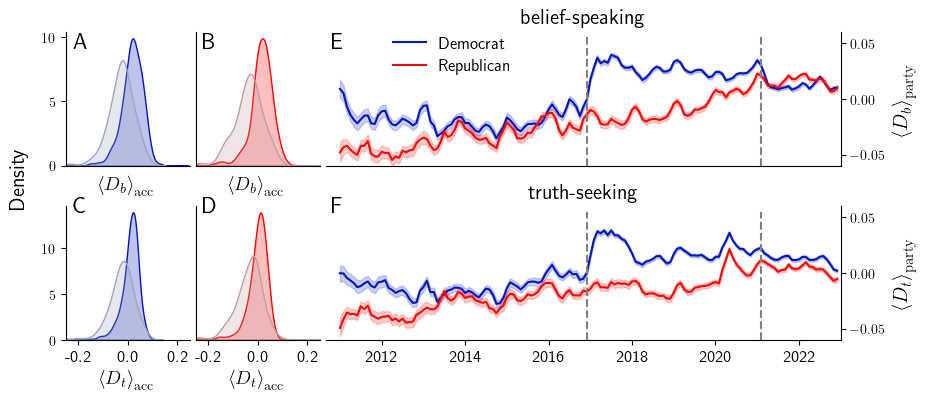

In [11]:
fname = "fig2"
cutoff = 2009
fig = plt.figure(figsize=(10, 4))

gs = GridSpec(2, 6, figure=fig, hspace=0.3, wspace=0.05)
ax1 = fig.add_subplot(gs[0, 2:])
ax2 = fig.add_subplot(gs[1, 2:])
ax3 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[0, 1])
ax6 = fig.add_subplot(gs[1, 1])

# timelines
for ax, df, label, title in zip([ax1, ax2], [belief, truth], 
                    ["belief", "truth"], ["belief-speaking", "truth-seeking"]):
    for party, color in zip(["Democrat", "Republican"], [demblue, repred]):
        subset = df[(df["year"] > cutoff) & (df["party"] == party)].copy()
        ax.plot(range(len(subset)), subset[label + "_mean"].rolling(3).mean(),
                color=color, label=party)
        ax.fill_between(range(len(subset)), 
                         subset[label + "_perc_2.5"].rolling(3).mean(),
                         subset[label + "_perc_97.5"].rolling(3).mean(),
                         color=color, alpha=0.2)

    #ax.set_ylim(0.35, 0.62)
    ax.set_xlim(-2, 146)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(title, fontsize=15)
    #ax.plot([59, 59], [0, 0.2], "--", color="grey")
    #ax.plot([107, 107], [0, 0.2], "--", color="grey")
    
    if label == "truth":
        ax.set_xticks([14, 38, 62, 86, 110, 134])
        ax.set_xticklabels(["2012", "2014", "2016", "2018", "2020", "2022"],
                           fontsize=12)
    else:
        ax.set_xticks([])
        ax.legend(loc=2, fontsize=12, bbox_to_anchor=[0.1, 1.08, 0, 0], frameon=False)
        
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_yticks([-0.05, 0.0, 0.05])
    ax.set_ylim([-0.06, 0.06])
    #ax.set_yticklabels([0.4, 0.5, 0.6], fontsize=12)
    if label == "belief":
        ax.set_ylabel("$\\left<D_b\\right>_\\mathrm{party}$", fontsize=15)
    else:
        ax.set_ylabel("$\\left<D_t\\right>_\\mathrm{party}$", fontsize=15)

    
# marginal distributions
axes_grid = np.asarray([[ax3, ax5], [ax4, ax6]])
label_dict = {"belief":"belief-speaking", "truth":"truth-seeking"}
palettes = {"Democrat":[demgrey, demblue], "Republican":[repgrey, repred]}

for i, comp in enumerate(["belief", "truth"]):
    label = label_dict[comp]
    axes = axes_grid[i, 0:]
    
    cols = ["party", f"avg_{comp}_score_2010_to_2013", f"avg_{comp}_score_2019_to_2022"]
    subset = users[users["party"].isin(["Democrat", "Republican"])][cols].copy()
    subset = subset.melt(
        id_vars=["party"], 
        var_name="period", 
        value_name=f"avg_{comp}_score"
    )
    subset["period"] = subset["period"].replace({
        f"avg_{comp}_score_2010_to_2013":"2010_to_2013",
        f"avg_{comp}_score_2019_to_2022":"2019_to_2022"
    })
    
    for party, ax, in zip(["Democrat", "Republican"], axes):
        legend = False
        df = subset[subset["party"] == party]
        sns.kdeplot(
            ax=ax,
            data=df,
            x=f"avg_{comp}_score",
            hue="period",
            hue_order=["2010_to_2013", "2019_to_2022"],
            palette=palettes[party],
            fill=True,
            legend=False,
            common_norm=False
        )
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if party == "Republican": 
            ax.set_ylabel("")
            ax.set_yticks([])
        else:
            #ax.set_yticks([0, 5, 10, 15])
            #ax.set_yticklabels([0, 5, 10, 15], fontsize=12)
            if comp == "belief":
                ax.set_ylabel("Density", fontsize=15)
                ax.yaxis.set_label_coords(-0.3, -0.1)
            else:
                ax.set_ylabel("")
        ax.set_xlim(-0.25, 0.25)
        #ax.set_ylim(0, 15)
        
        if comp == "belief":
            ax.set_xticks([])
            ax.set_xlabel("$\\left<D_b\\right>_\\mathrm{acc}$", fontsize=14)
        else:
            ax.set_xticks([-0.2, 0, 0.2])
            ax.set_xticklabels([-0.2, 0.0, 0.2], fontsize=12)
            ax.set_xlabel("$\\left<D_t\\right>_\\mathrm{acc}$", fontsize=14)
        
                
# election indications
ax1.plot([73, 73], [-0.06, 0.055], '--', color="grey")
ax1.plot([123, 123], [-0.06, 0.055], '--', color="grey")
ax2.plot([73, 73], [-0.06, 0.055], '--', color="grey")
ax2.plot([123, 123], [-0.06, 0.055], '--', color="grey")

fig.text(0.132, 0.84, "A", fontsize=16)
fig.text(0.132, 0.43, "C", fontsize=16)
fig.text(0.262, 0.84, "B", fontsize=16)
fig.text(0.262, 0.43, "D", fontsize=16)
fig.text(0.39, 0.84, "E", fontsize=16)
fig.text(0.39, 0.43, "F", fontsize=16)

plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Fig 3: misinformation scatter & prediction scores

In [66]:
# read tweet data
parties = ["Democrat", "Republican"]
fname = "tweets.csv.gzip"
cols = ["party", "avg_belief_score", "avg_truth_score", "NG_score"]
tweets = pd.read_csv(
    join(src, "tweets", fname),
    compression="gzip", 
    usecols=cols
)
# drop tweets without NewsGuard score or belief-speaking/truth-seeking similarity
tweets = tweets.dropna() 
tweets = tweets[tweets["party"].isin(parties)]
# transform variables to fit transformations in the regression models
tweets["NG_score"] = tweets["NG_score"] / 100

In [67]:
# draw a sample of tweets and apply vertical jitter
tweet_sample = tweets.sample(n=100000, random_state=42).copy()
jitter = np.asarray([np.random.rand() for i in range(len(tweet_sample))])
jitter = jitter / 50
tweet_sample["NG_score"] = tweet_sample["NG_score"] + jitter

In [68]:
# read the predictions of the regression model for tweets
cols = ["NG", "belief", "truth", "ymin", "ymax", "party"]
fname = "LME_predictions_tweets_belief.csv"
tweet_belief_pred = pd.read_csv(join(src, "tweets", fname), usecols=cols)
fname = "LME_predictions_tweets_truth.csv"
tweet_truth_pred = pd.read_csv(join(src, "tweets", fname), usecols=cols)

tweet_belief_pred_dem = tweet_belief_pred[tweet_belief_pred["party"] == "Democrat"]
tweet_belief_pred_rep = tweet_belief_pred[tweet_belief_pred["party"] == "Republican"]
tweet_truth_pred_dem = tweet_truth_pred[tweet_truth_pred["party"] == "Democrat"]
tweet_truth_pred_rep = tweet_truth_pred[tweet_truth_pred["party"] == "Republican"]

In [89]:
src = "../../data/"
fname = "articles.csv.gzip"
cols = ["NG_score", "party_count", "avg_belief_score", "avg_truth_score", "party"]
articles = pd.read_csv(
    join(src, "articles", fname),
    compression="gzip",
    usecols=cols
)
articles = articles.dropna()

In [90]:
# transform variables to fit transformations in the regression models
articles["NG_score"] = articles["NG_score"] / 100

In [91]:
bipartisan_articles = articles[articles["party_count"] > 1].copy()
articles = articles[articles["party_count"] == 1]

In [92]:
# read the predictions of the regression model for articles
fname = "OLS_predictions_articles.csv"
predictions = pd.read_csv(join(src, "articles", fname))
article_belief_pred_dem = predictions[(predictions["party"] == "Democrat") &\
                              (predictions["honesty_component"] == "belief")]
article_belief_pred_rep = predictions[(predictions["party"] == "Republican") &\
                              (predictions["honesty_component"] == "belief")]
article_truth_pred_dem = predictions[(predictions["party"] == "Democrat") &\
                              (predictions["honesty_component"] == "truth")]
article_truth_pred_rep = predictions[(predictions["party"] == "Republican") &\
                              (predictions["honesty_component"] == "truth")]

In [93]:
# draw a sample of articles and apply vertical jitter
article_sample = articles.sample(n=100000, random_state=42).copy()
jitter = np.asarray([np.random.rand() for i in range(len(article_sample))])
jitter = jitter / 50
article_sample["NG_score"] = article_sample["NG_score"] + jitter

In [94]:
def plot_prediction(ax, preds, component):
    '''Plots the prediction from regression models and confidence intervals.'''
    parties = ["Democrat", "Republican"]
    colors = [demblue, repred]    
    for pred, color, party in zip(preds, colors, parties):
        ax.plot(pred[component], pred["NG"], color=color, label=party,
                linewidth=3)
        ax.fill_between(pred[component], pred["NG"], pred["ymin"], 
                        alpha=0.2, color=color)
        ax.fill_between(pred[component], pred["NG"], pred["ymax"], 
                        alpha=0.2, color=color)

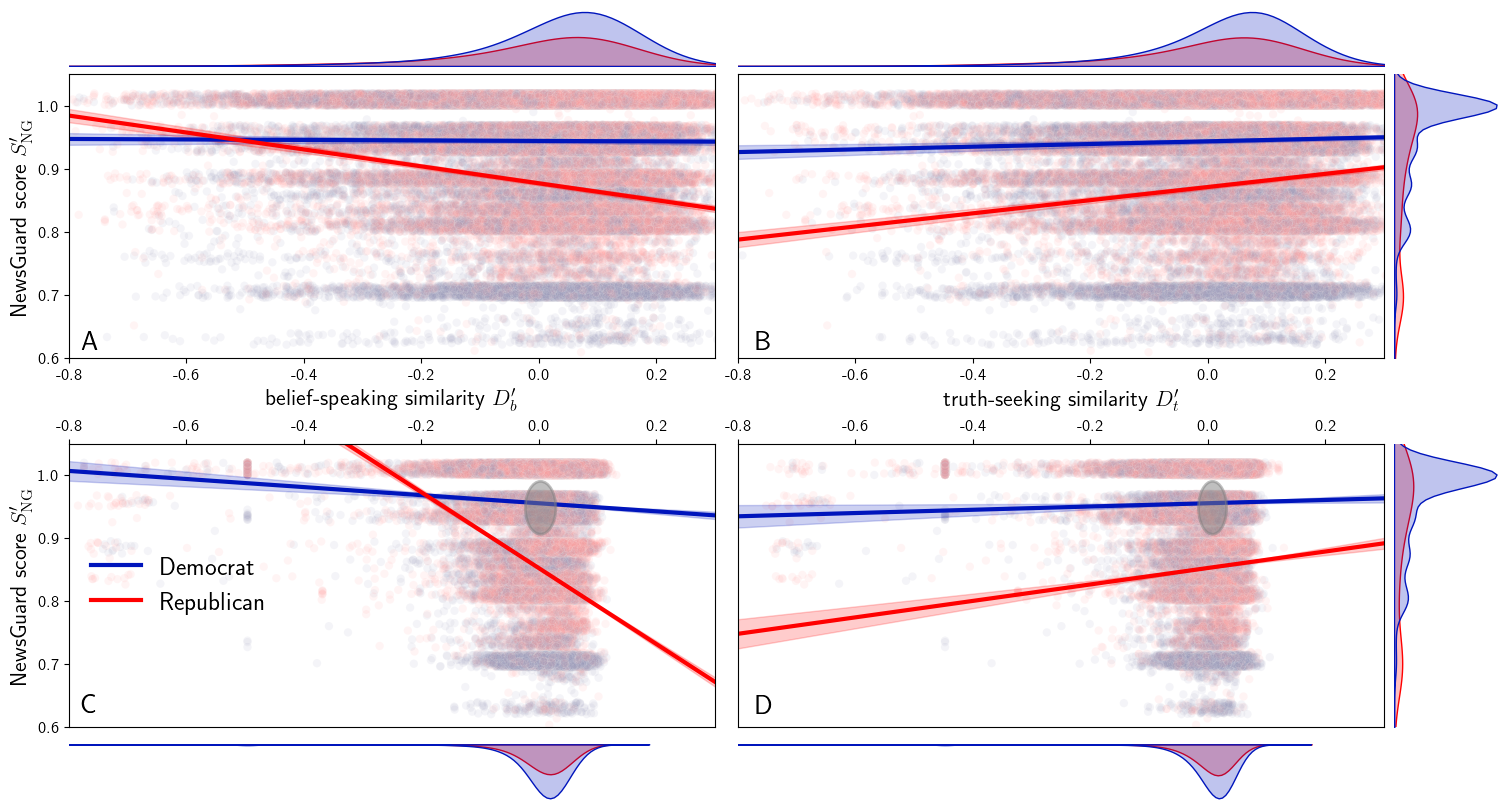

In [115]:
fname = "fig3"

# figure and subplot setup
figsize = (15, 8)
gridspec_kw = dict(
    nrows=4, ncols=3,
    width_ratios=[6, 6, 1],
    height_ratios=[1, 5, 5, 1],
    #hspace=0.5
)

fig = plt.figure(figsize=figsize, constrained_layout=True)
axs = fig.add_gridspec(**gridspec_kw).subplots()

axs[0, 2].remove()
axs[3, 2].remove()
axs[3, 0].invert_yaxis()
axs[3, 1].invert_yaxis()

ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]
ax5 = axs[1, 2]
ax6 = axs[2, 0]
ax7 = axs[2, 1]
ax8 = axs[2, 2]
ax9 = axs[3, 0]
ax10 = axs[3, 1]

palette1 = [demblue, repred]
palette2 = ["#ff9c9c", "#9c9cbc"]

# marginal distributions of belief-speaking and truth-seeking similarities
for df, comp, ax in zip([tweets] * 2 + [articles] * 2, ["belief", "truth"] * 2,
    [ax1, ax2, ax9, ax10]):
    sns.kdeplot(
        data=df, bw_adjust=3, x=f"avg_{comp}_score", hue="party", alpha=0.25,
        hue_order=parties, palette=palette1, fill=True, ax=ax, legend=False
    )
    
# marginal distributions of NewsGuard scores
for df, ax in zip([tweets, articles], [ax5, ax8]):
    sns.kdeplot(
        data=df, bw_adjust=3, y="NG_score", hue="party", alpha=0.25,
        hue_order=parties, palette=palette1, fill=True, ax=ax, legend=False
    )
    
# scatterplots of individual tweet and article values
for df, comp, ax in zip(
    [tweet_sample, tweet_sample, article_sample, article_sample],
    ["belief", "truth", "belief", "truth"],
    [ax3, ax4, ax6, ax7]):
    sns.scatterplot(
        data=df, x=f"avg_{comp}_score", y="NG_score", hue="party", ax=ax, 
        alpha=0.1, hue_order=parties, palette=palette2, legend=False
    )
    
# predictions from the regression models
plot_prediction(ax3, (tweet_belief_pred_dem, tweet_belief_pred_rep), "belief")
plot_prediction(ax4, (tweet_truth_pred_dem, tweet_truth_pred_rep), "truth")
plot_prediction(ax6, (article_belief_pred_dem, article_belief_pred_rep), "belief")
plot_prediction(ax7, (article_truth_pred_dem, article_truth_pred_rep), "truth")

# axis label and tick cosmetics
sns.despine(ax=axs[0, 0], top=True, right=True, left=True, trim=True)
sns.despine(ax=axs[0, 1], top=True, right=True, left=True, trim=True)
sns.despine(ax=axs[1, 2], top=True, right=True, bottom=True, trim=True)
sns.despine(ax=axs[2, 2], top=True, right=True, bottom=True, trim=True)
sns.despine(ax=axs[3, 0], left=True, right=True, bottom=True, trim=True)
sns.despine(ax=axs[3, 1], left=True, right=True, bottom=True, trim=True)

for ax in [ax1, ax2, ax5, ax8, ax9, ax10]:
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    
for ax in [ax4, ax7]:
    ax.set_ylabel("")
    ax.set_yticks([])
    
for ax in [ax3, ax4, ax6, ax7]:
    ax.set_xlim(-0.8, 0.3)
    ax.set_ylim(0.6, 1.05)
    
for ax in [ax6, ax7]:
    ax.set_xlabel("")
    ax.set_xticks([-0.8, -0.6, -0.4, -0.2, 0.0, 0.2])
    ax.set_xticklabels([-0.8, -0.6, -0.4, -0.2, 0.0, 0.2], fontsize=12)
    ax.xaxis.tick_top()
    
for ax in [ax3, ax4]:
    ax.set_xticks([-0.8, -0.6, -0.4, -0.2, 0.0, 0.2])
    ax.set_xticklabels([-0.8, -0.6, -0.4, -0.2, 0.0, 0.2], fontsize=12)
    
for ax in [ax1, ax2, ax9, ax10]:
    ax.set_xlim(-0.8, 0.3)
    
for ax in [ax1, ax2]:
    ax.spines['bottom'].set_visible(False)
    
for ax in [ax9, ax10]:
    ax.spines['top'].set_visible(False)
    
for ax in [ax5, ax8]:
    ax.set_ylim(0.6, 1.05)
    ax.spines['left'].set_visible(False)

for ax in [ax3, ax6]:
    ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_yticklabels([0.6, 0.7, 0.8, 0.9, 1.0], fontsize=12)
    
ax3.set_ylabel("NewsGuard score $S_\\mathrm{NG}'$", fontsize=16)
ax6.set_ylabel("NewsGuard score $S_\\mathrm{NG}'$", fontsize=16)
ax3.set_xlabel("belief-speaking similarity $D_b'$", fontsize=16)
ax4.set_xlabel("truth-seeking similarity $D_t'$", fontsize=16)

ax6.legend(frameon=False, loc=6, fontsize=18)
fig.text(0.05, 0.57, "A", fontsize=20)
fig.text(0.50, 0.57, "B", fontsize=20)
fig.text(0.05, 0.115, "C", fontsize=20)
fig.text(0.50, 0.115, "D", fontsize=20)

e_belief = Ellipse(
    (bipartisan_articles["avg_belief_score"].mean(),
     bipartisan_articles["NG_score"].mean()),
    bipartisan_articles["avg_belief_score"].std(),
    bipartisan_articles["NG_score"].std(),
    angle=0,
    linewidth=2,
    #fill=False, 
    zorder=2,
    color="grey",
    alpha=0.5
)
e_truth = Ellipse(
    (bipartisan_articles["avg_truth_score"].mean(),
     bipartisan_articles["NG_score"].mean()),
    bipartisan_articles["avg_truth_score"].std(),
    bipartisan_articles["NG_score"].std(),
    angle=0,
    linewidth=2,
    #fill=False, 
    zorder=2,
    color="grey",
    alpha=0.5
)

ax6.add_patch(e_belief)
ax7.add_patch(e_truth)

plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white", dpi=150)
#plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
#plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

# Extended data

## Fig 1: Three-way interaction

In [39]:
fname = "LME_predictions_tweets_threeway.csv"
preds = pd.read_csv(join(src, "tweets", fname))

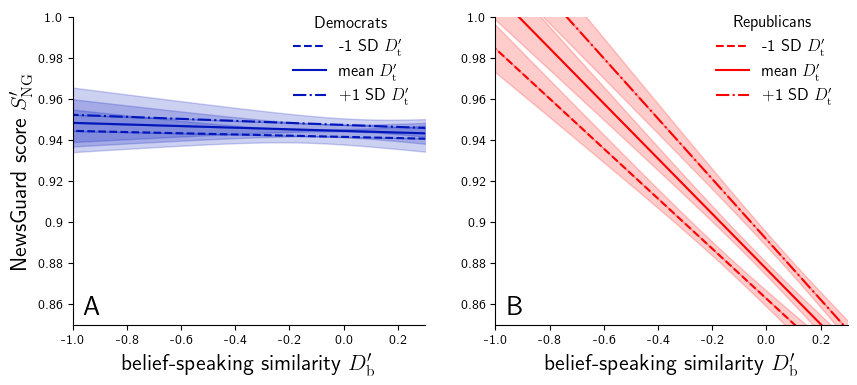

In [40]:
fname = "ext_fig1"
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
alpha = 0.2
for mod, linestyle, label in zip(preds["mod2_group"].unique(), ["--", "-", "-."],
        ["-1 SD $D_\\mathrm{t}'$", "mean $D_\\mathrm{t}'$", "+1 SD $D_\\mathrm{t}'$"]):
    for ax, party, color in zip(axes, ["Democrat", "Republican"], [demblue, repred]):
        subset = preds[(preds["mod2_group"] == mod) & (preds["party"] == party)]
        ax.plot(subset["belief"], subset["NG"], linestyle, color=color,
                label=label)
        ax.fill_between(subset["belief"], subset["NG"], subset["ymax"],
                        color=color, alpha=alpha)
        ax.fill_between(subset["belief"], subset["NG"], subset["ymin"],
                        color=color, alpha=alpha)
yticks = [0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.0]
xticks = [-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2]
for ax, party in zip(axes, ["Democrats", "Republicans"]):
    ax.set_ylim(0.85, 1.0)
    ax.set_xlim(-1.0, 0.3)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.set_xlabel("belief-speaking similarity $D_\\mathrm{b}'$", fontsize=16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    legend = ax.legend(loc=1, frameon=False, fontsize=12, title=party,
                       bbox_to_anchor=[1, 1.05, 0, 0])
    plt.setp(legend.get_title(),fontsize=12)
    
axes[0].set_ylabel("NewsGuard score $S_\\mathrm{NG}'$", fontsize=16)
fig.text(0.135, 0.135, "A", fontsize=20)
fig.text(0.56, 0.135, "B", fontsize=20)
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Fig 2: Dictionary robustness

In [8]:
fname = "LME_results_dictionary_robustness.csv"
regression_results = pd.read_csv(join(src, "tweets", fname))

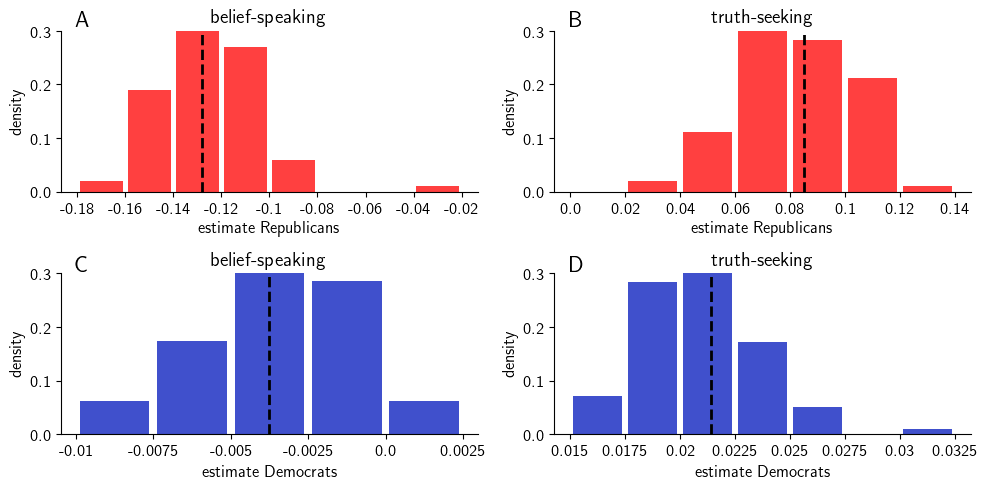

In [21]:
dst = "../../plots"
fname = "ext_fig2"

bins1 = [-0.18, -0.16, -0.14, -0.12, -0.10, -0.08, -0.06, -0.04, -0.02]
bins2 = [0.0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14]
bins3 = [-0.01, -0.0075, -0.005, -0.0025, 0.00, 0.0025]
bins4 = [0.015, 0.0175, 0.02, 0.0225, 0.025, 0.0275, 0.030, 0.0325]
ymax = 0.3
yticks = [0.0, 0.1, 0.2, 0.3]

# estimates from the linear mixed effects model in R
estimates = [[-0.1282, 0.0851], [-0.0037, 0.0215]]

fig, axes = plt.subplots(2, 2, figsize=(10, 5))
for ax_row, col, color, party, bin_collection, estimate_list in zip(
    [axes[0, 0:], axes[1, 0:]],
    ["{}:party[T.Republican]_estimate", "{}_estimate"],
    [repred, demblue], ["Republicans", "Democrats"],
    [[bins1, bins2], [bins3, bins4]], estimates
):
    for ax, comp, bins, title, estimate in zip(ax_row, ["belief", "truth"], 
        bin_collection, ["belief-speaking", "truth-seeking"], estimate_list
    ):
        sns.histplot(
            ax=ax,
            data=regression_results, 
            x=col.format(comp),
            stat="probability", 
            color=color,
            edgecolor=None,
            shrink=0.9,
            bins=np.asarray(bins)
        )
        ax.set_ylabel("density", fontsize=12)
        ax.set_xlabel(f"estimate {party}", fontsize=12)

        ax.plot(
            [estimate, estimate], 
            [0, ymax - ymax * 0.01],
            '--',
            color="k",
            linewidth=2,
            label="full dictionary"
            )
        
        ax.set_ylim(0, ymax)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_title(title, fontsize=14)
        ax.set_xticks(bins)
        ax.set_xticklabels(bins, fontsize=12)
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks, fontsize=12)

fig.text(0.08, 0.935, "A", fontsize=16)
fig.text(0.575, 0.935, "B", fontsize=16)
fig.text(0.08, 0.445, "C", fontsize=16)
fig.text(0.575, 0.445, "D", fontsize=16)
fig.tight_layout()
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Fig 3: coverage

In [152]:
fname = "NG_coverage.csv.gzip"
coverage = pd.read_csv(join(src, "bootstrapping", fname), compression="gzip")

In [153]:
coverage = coverage[["year", "month", "NG_coverage", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", "std"])
coverage = coverage.reset_index()
coverage.columns = ["year", "month", "party", "NG_coverage_mean", "NG_coverage_std"]

In [154]:
fname = "independent_coverage.csv.gzip"
independent_coverage = pd.read_csv(join(src, "bootstrapping", fname), compression="gzip")

In [155]:
independent_coverage = independent_coverage\
    [["year", "month", "independent_coverage", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", "std"])
independent_coverage = independent_coverage.reset_index()
independent_coverage.columns = ["year", "month", "party", 
                    "independent_coverage_mean", "independent_coverage_std"]

In [156]:
def plot_coverage(ax, data, ycol, cutoff=2011):
    parties = ["Democrat", "Republican"]
    for party, color in zip(parties, [demblue, repred]):
        df = data[(data["year"] > cutoff) & (data["party"] == party)]
        ax.plot(range(len(df)), df[ycol + "_mean"], color=color, label=party)
        ax.fill_between(range(len(df)), 
                         df[ycol + "_mean"],
                         df[ycol + "_mean"] + df[ycol + "_std"],
                         color=color, alpha=0.2)
        ax.fill_between(range(len(df)), 
                         df[ycol + "_mean"],
                         df[ycol + "_mean"] - df[ycol + "_std"],
                         color=color, alpha=0.2)
        ax.set_ylim(0, 0.68)
        ax.set_yticks([0, 0.2, 0.4, 0.6])
        ax.set_yticklabels(["0%", "20%", "40%", "60%"], fontsize=12)

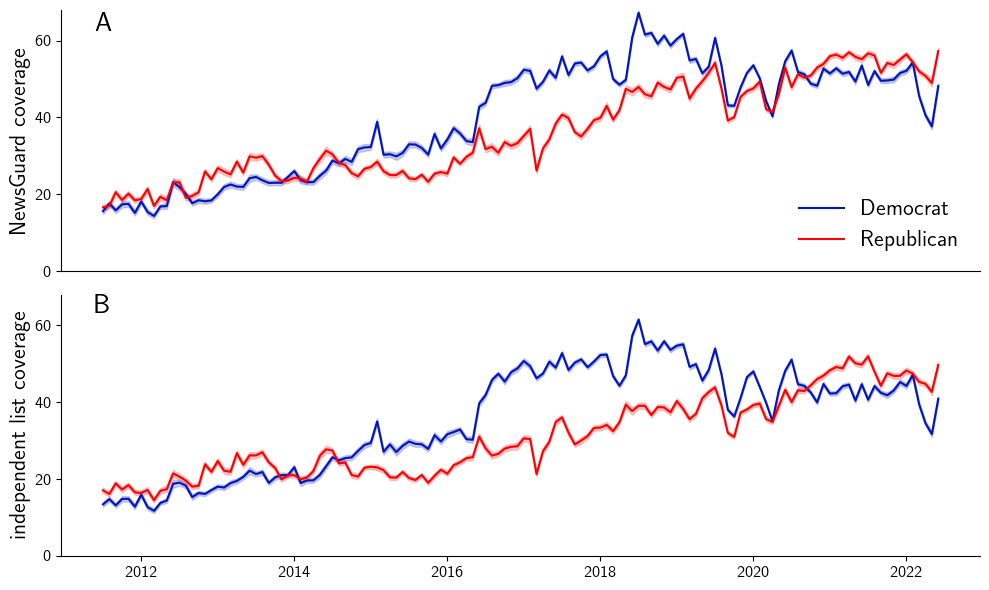

In [157]:
fname = "ext_fig3"
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_coverage(axes[0], coverage, "NG_coverage")
plot_coverage(axes[1], independent_coverage, "independent_coverage")

axes[0].set_xticks([])
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
axes[1].set_xticks(range(6, 131, 24))
axes[1].set_xticklabels(range(2012, 2023, 2), fontsize=12)
axes[0].legend(loc=4, fontsize=16, frameon=False)
axes[0].set_ylabel("NewsGuard coverage", fontsize=16)
axes[1].set_ylabel("independent list coverage", fontsize=16)
fig.tight_layout()
fig.text(0.1, 0.94, "A", fontsize=20)
fig.text(0.1, 0.47, "B", fontsize=20)
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Fig 4: full scatterplots

In [116]:
# read tweet data
parties = ["Democrat", "Republican"]
fname = "tweets.csv.gzip"
cols = ["party", "avg_belief_score", "avg_truth_score", "NG_score", "retweeted"]
tweets = pd.read_csv(
    join(src, "tweets", fname),
    compression="gzip", 
    usecols=cols
)
# drop retweets
tweets = tweets[tweets["retweeted"] == False] 
tweets = tweets.drop(columns=["retweeted"])
# drop tweets without NewsGuard score or belief-speaking/truth-seeking similarity
tweets = tweets.dropna() 
tweets = tweets[tweets["party"].isin(parties)]
# transform variables to fit transformations in the regression models
tweets["NG_score"] = tweets["NG_score"] / 100
# apply vertical jitter
jitter = np.asarray([np.random.rand() for i in range(len(tweets))])
jitter = jitter / 50
tweets["NG_score"] = tweets["NG_score"] + jitter

In [117]:
fname = "articles.csv.gzip"
articles = pd.read_csv(
    join(src, "articles", fname),
    compression="gzip"
)

# transform variables to fit transformations in the regression models
articles["NG_score"] = articles["NG_score"] / 100
articles["avg_belief_score"] = articles["avg_belief_score"] - articles["avg_belief_score"].mean()
articles["avg_truth_score"] = articles["avg_truth_score"] - articles["avg_truth_score"].mean()
# apply vertical jitter
jitter = np.asarray([np.random.rand() for i in range(len(articles))])
jitter = jitter / 50
articles["NG_score"] = articles["NG_score"] + jitter

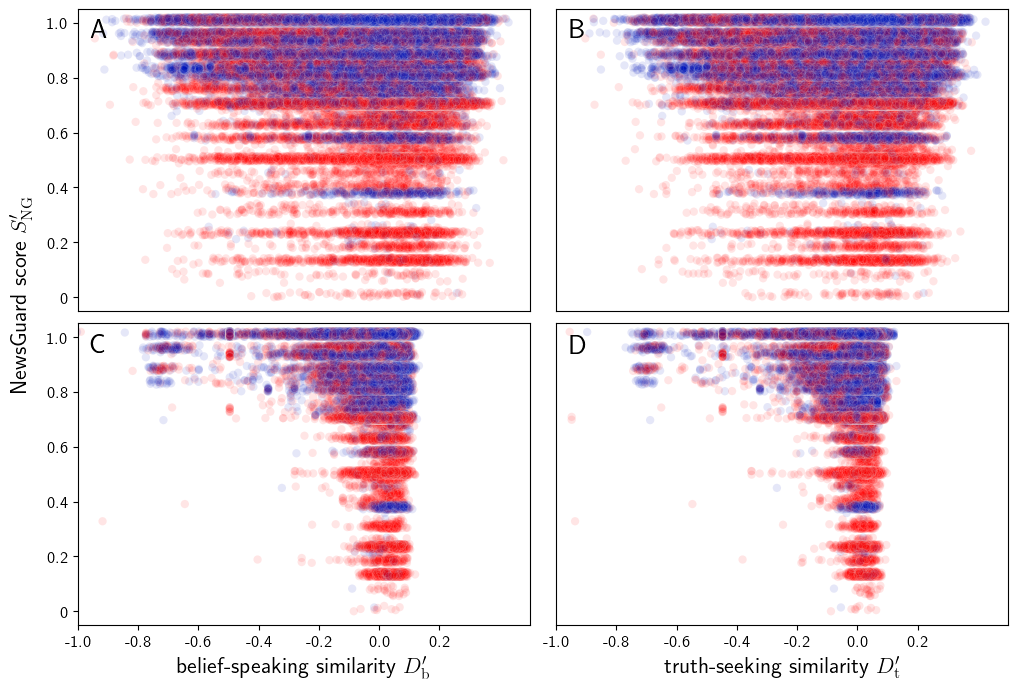

In [118]:
fname = "ext_fig4"
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 18, figure=fig, hspace=0.04, wspace=1)
ax0 = fig.add_subplot(gs[0, 0:9])
ax1 = fig.add_subplot(gs[0, 9:])
ax2 = fig.add_subplot(gs[1, 0:9])
ax3 = fig.add_subplot(gs[1, 9:])

parties = ["Democrat", "Republican"]
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
xticks = [-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2]

axes = [ax0, ax1, ax2, ax3]
for df, comp, ax in zip(
    [tweets, tweets, articles, articles],
    ["belief", "truth", "belief", "truth"],
    axes):
    sns.scatterplot(
        data=df, x=f"avg_{comp}_score", y="NG_score", hue="party", ax=ax, 
        alpha=0.1, hue_order=parties, palette=[demblue, repred], legend=False
    )
    ax.set_xlim(-1.0, 0.5)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
for ax in [ax1, ax3]:
    ax.set_yticks([])
for ax in [ax0, ax1]:
    ax.set_xticks([])
for ax in [ax2, ax3]:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize=12)
for ax in [ax0, ax2]:
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=12)

ax2.set_ylabel("NewsGuard score $S_\mathrm{NG}'$", fontsize=16)
ax2.yaxis.set_label_coords(-0.1, 1.1)
ax2.set_xlabel("belief-speaking similarity $D_\\mathrm{b}'$", fontsize=16)
ax3.set_xlabel("truth-seeking similarity $D_\\mathrm{t}'$", fontsize=16)

fig.text(0.135, 0.845, "A", fontsize=20)
fig.text(0.535, 0.845, "B", fontsize=20)
fig.text(0.135, 0.45, "C", fontsize=20)
fig.text(0.535, 0.45, "D", fontsize=20)
    
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white", dpi=150)
#plt.savefig(join(dst, fname + ".pdf"),bbox_inches="tight", facecolor="white")

# Supplementary Information

## Fig 7: Positive and negative sentiment VADER score timelines

In [18]:
# note: the files are called "LIWC_ ..." even though they contain VADER scores
fname = "LIWC.csv.gzip"
score_bootstrap = pd.read_csv(join(src, "bootstrapping", fname), compression="gzip")
fname = "LIWC_belief.csv.gzip"
score_belief_bootstrap = pd.read_csv(join(src, "bootstrapping", fname), compression="gzip")
fname = "LIWC_truth.csv.gzip"
score_truth_bootstrap = pd.read_csv(join(src, "bootstrapping", fname), compression="gzip")
fname = "LIWC_neutral_belief.csv.gzip"
score_neutral_belief_bootstrap = pd.read_csv(join(src, "bootstrapping", fname), compression="gzip")
fname = "LIWC_neutral_truth.csv.gzip"
score_neutral_truth_bootstrap = pd.read_csv(join(src, "bootstrapping", fname), compression="gzip")

In [19]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [20]:
cols = ["VADER_pos_share", "VADER_neg_share"]
scores = score_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
score_belief = score_belief_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
score_truth = score_truth_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
score_neutral_belief = score_neutral_belief_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
score_neutral_truth = score_neutral_truth_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()

In [21]:
def plot_component(ax, component, component_title, baseline, col, ylim, 
                     window=3, years=False, yticks=[0, 1, 2, 3, 4]):
    dem = component[component["party"] == "Democrat"].copy()
    rep = component[component["party"] == "Republican"].copy()
    
    dem_bl = baseline[baseline["party"] == "Democrat"]
    rep_bl = baseline[baseline["party"] == "Republican"]
    

    dem_avg = dem[col]["mean"].rolling(window).mean().values /\
        dem_bl[col]["mean"].rolling(window).mean().values
    dem_lo = dem[col]["percentile_2.5"].rolling(window).mean().values /\
        dem_bl[col]["percentile_2.5"].rolling(window).mean().values
    dem_hi = dem[col]["percentile_97.5"].rolling(window).mean().values /\
        dem_bl[col]["percentile_97.5"].rolling(window).mean().values
    rep_avg = rep[col]["mean"].rolling(window).mean().values /\
        rep_bl[col]["mean"].rolling(window).mean().values
    rep_lo = rep[col]["percentile_2.5"].rolling(window).mean().values /\
        rep_bl[col]["percentile_2.5"].rolling(window).mean().values
    rep_hi = rep[col]["percentile_97.5"].rolling(window).mean().values /\
        rep_bl[col]["percentile_97.5"].rolling(window).mean().values
    
    ax.plot(range(len(dem)), dem_avg, color=demblue)
    ax.fill_between(range(len(dem)), dem_lo, dem_hi,
                    color=demblue, alpha=alpha)
    
    ax.plot(range(len(rep)), rep_avg, color=repred)
    ax.fill_between(range(len(rep)), rep_lo, rep_hi,
                    color=repred, alpha=alpha)
        
    if years:
        ax.set_xticks([14, 38, 62, 86, 110, 134])
        ax.set_xticklabels(["2012", "2014", "2016", "2018", "2020", "2022"],
                           fontsize=16)
    else:
        ax.set_xticks([])
        
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=16)
    ax.set_xlim(-1, len(dem) + 5)
    ax.set_ylim(ylim[0], ylim[1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_title(component_title, fontsize=24)
    
    ax.plot([73, 73], [ax.get_ylim()[0], ax.get_ylim()[1]], '--', color="grey")
    ax.plot([123, 123], [ax.get_ylim()[0], ax.get_ylim()[1]], '--', color="grey")

    
    # indicate baseline
    ax.plot([-1, len(dem) -1 ], [1, 1], '--', color="k")

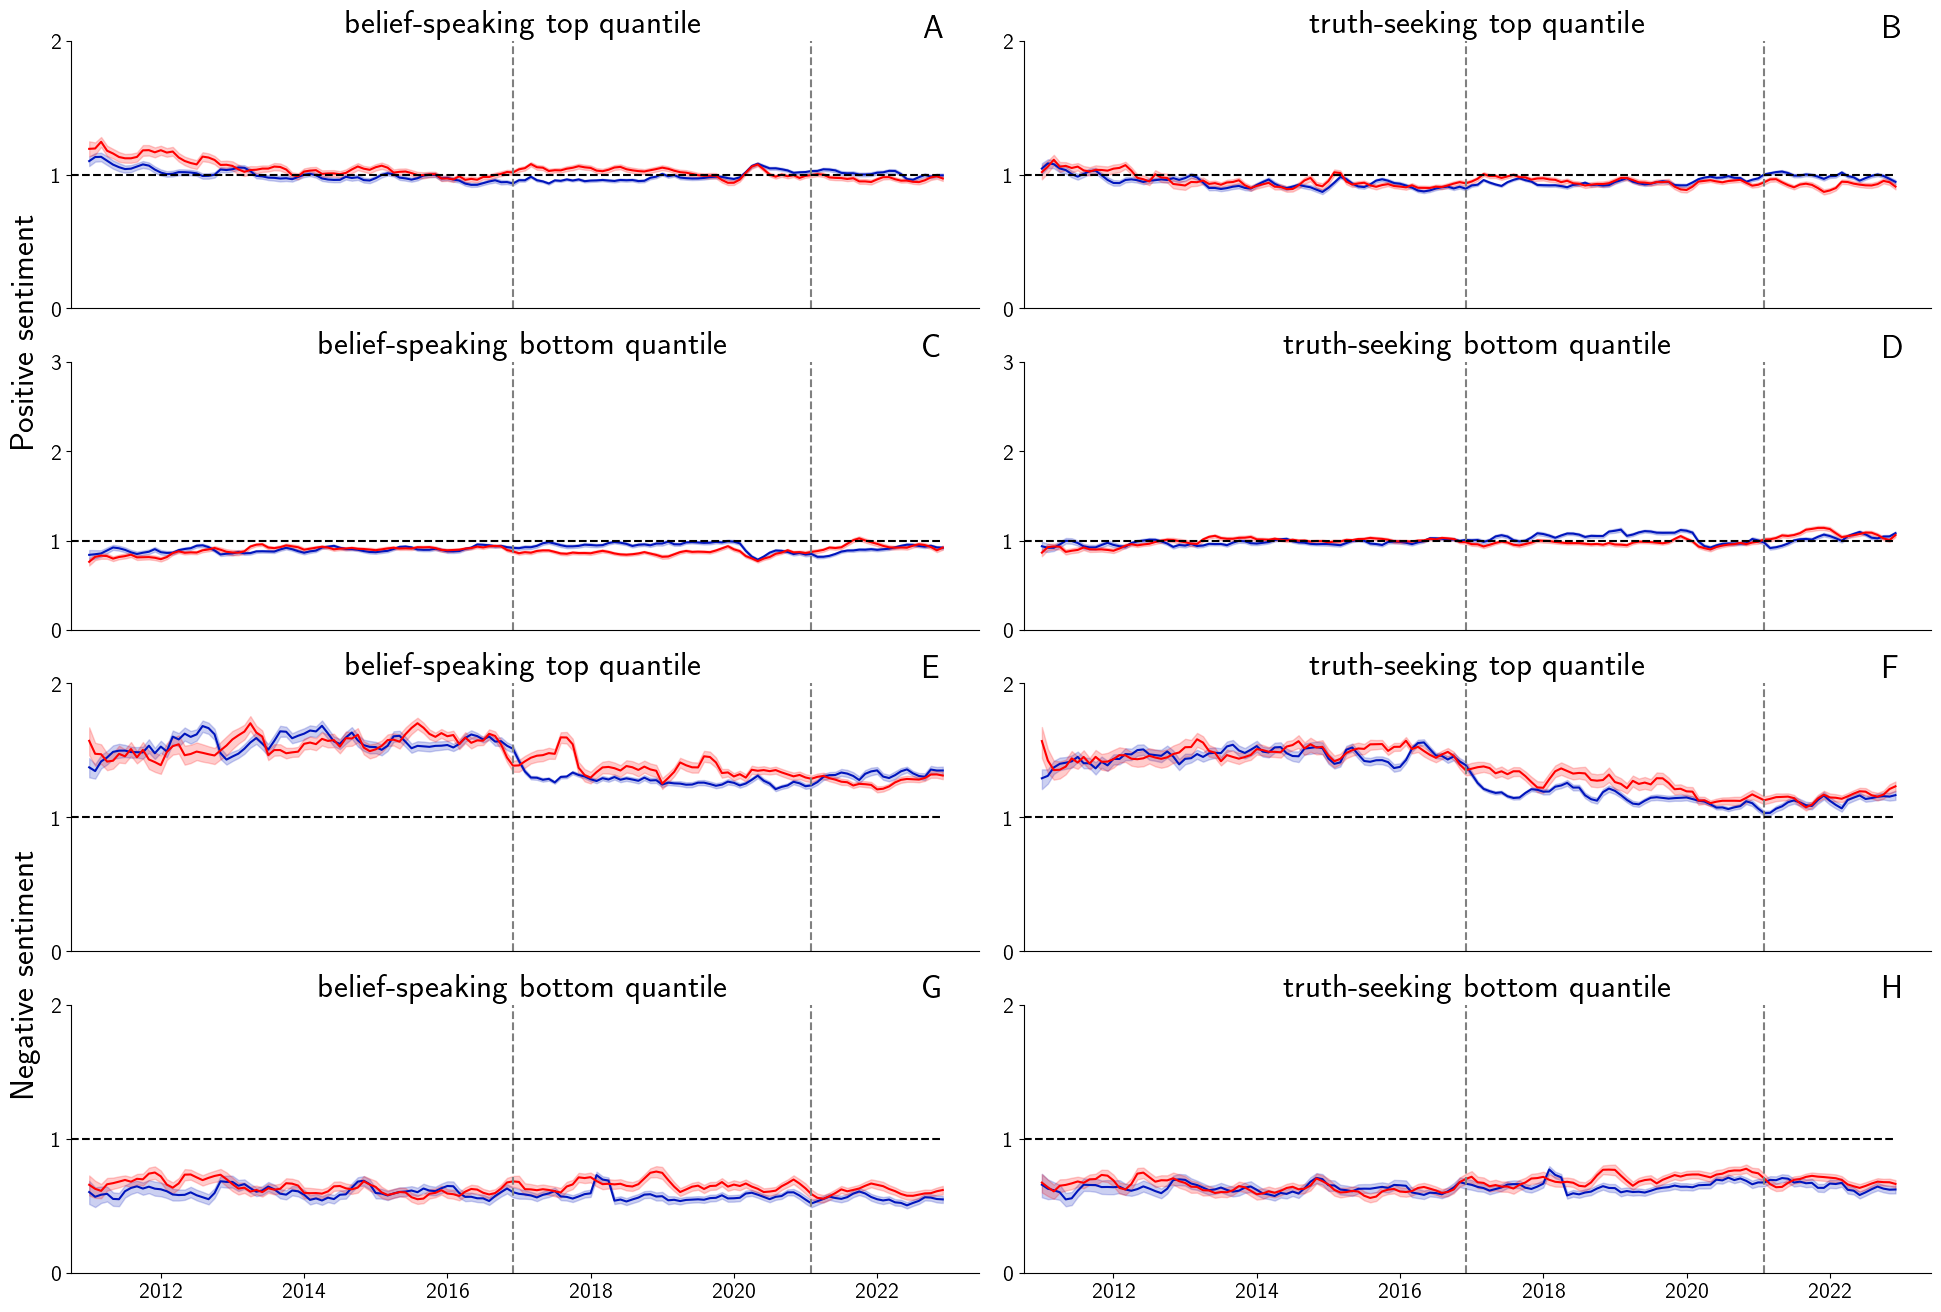

In [23]:
fname = "SI_fig7"
alpha = 0.2

fig = plt.figure(figsize=(24, 16))

gs = GridSpec(8, 2, figure=fig, hspace=0.5, wspace=0.05)
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[0:2, 1])
ax3 = fig.add_subplot(gs[4:6, 0])
ax4 = fig.add_subplot(gs[4:6, 1])

ax5 = fig.add_subplot(gs[2:4, 0])
ax6 = fig.add_subplot(gs[2:4, 1])
ax7 = fig.add_subplot(gs[6:8, 0])
ax8 = fig.add_subplot(gs[6:8, 1])

 
data = {
    "belief-speaking":score_belief,
    "truth-seeking":score_truth,
    "neutral_belief":score_neutral_belief,
    "neutral_truth":score_neutral_truth,
    "baseline":scores
}

ylims = {
    "VADER_pos_share":[0, 2],
    "VADER_neg_share":[0, 2],
}

plot_component(ax1, data["belief-speaking"], "belief-speaking top quantile", data["baseline"],
               "VADER_pos_share", [0, 2], window=3)
plot_component(ax2, data["truth-seeking"], "truth-seeking top quantile", data["baseline"],
               "VADER_pos_share", [0, 2], window=3)
plot_component(ax3, data["belief-speaking"], "belief-speaking top quantile", data["baseline"],
               "VADER_neg_share", ylims["VADER_neg_share"], window=3,
               yticks=[0, 1, 2])
plot_component(ax4, data["truth-seeking"], "truth-seeking top quantile", data["baseline"],
               "VADER_neg_share", ylims["VADER_neg_share"], window=3,
               yticks=[0, 1, 2])

plot_component(ax5, data["neutral_belief"], "belief-speaking bottom quantile", data["baseline"],
               "VADER_pos_share", [0, 3], window=3)
plot_component(ax6, data["neutral_truth"], "truth-seeking bottom quantile", data["baseline"],
               "VADER_pos_share", [0, 3], window=3)
plot_component(ax7, data["neutral_belief"], "belief-speaking bottom quantile", data["baseline"],
               "VADER_neg_share", [0, 2], window=3, years=True)
plot_component(ax8, data["neutral_truth"], "truth-seeking bottom quantile", data["baseline"],
               "VADER_neg_share", [0, 2], window=3, years=True)

ax1.set_ylabel("Positive sentiment", fontsize=24)
ax1.yaxis.set_label_coords(-0.035, -0.08)
ax3.set_ylabel("Negative sentiment", fontsize=24)
ax3.yaxis.set_label_coords(-0.035, -0.08)

fig.text(0.48, 0.882, "A", fontsize=24)
fig.text(0.88, 0.882, "B", fontsize=24)
fig.text(0.48, 0.682, "C", fontsize=24)
fig.text(0.88, 0.682, "D", fontsize=24)
fig.text(0.48, 0.482, "E", fontsize=24)
fig.text(0.88, 0.482, "F", fontsize=24)
fig.text(0.48, 0.282, "G", fontsize=24)
fig.text(0.88, 0.282, "H", fontsize=24)

plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Fig 8: Analytic, authentic and moral LIWC score timelines

In [24]:
fname = "LIWC.csv.gzip"
LIWC_bootstrap = pd.read_csv(join(src, "bootstrapping", fname), compression="gzip")
fname = "LIWC_belief.csv.gzip"
LIWC_belief_bootstrap = pd.read_csv(join(src, "bootstrapping", fname), compression="gzip")
fname = "LIWC_truth.csv.gzip"
LIWC_truth_bootstrap = pd.read_csv(join(src, "bootstrapping", fname), compression="gzip")
fname = "LIWC_neutral_belief.csv.gzip"
LIWC_neutral_belief_bootstrap = pd.read_csv(join(src, "bootstrapping", fname), compression="gzip")
fname = "LIWC_neutral_truth.csv.gzip"
LIWC_neutral_truth_bootstrap = pd.read_csv(join(src, "bootstrapping", fname), compression="gzip")

In [25]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [26]:
cols = ["LIWC_analytic_share", "LIWC_authentic_share", "LIWC_moral_share"]
LIWC = LIWC_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
LIWC_belief = LIWC_belief_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
LIWC_truth = LIWC_truth_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
LIWC_neutral_belief = LIWC_neutral_belief_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
LIWC_neutral_truth = LIWC_neutral_truth_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()

In [27]:
def plot_component(ax, component, component_title, baseline, col, ylim, 
                     window=3, years=False, yticks=[0.5, 1, 1.5]):
    dem = component[component["party"] == "Democrat"].copy()
    rep = component[component["party"] == "Republican"].copy()
    
    dem_bl = baseline[baseline["party"] == "Democrat"]
    rep_bl = baseline[baseline["party"] == "Republican"]
    

    dem_avg = dem[col]["mean"].rolling(window).mean().values /\
        dem_bl[col]["mean"].rolling(window).mean().values
    dem_lo = dem[col]["percentile_2.5"].rolling(window).mean().values /\
        dem_bl[col]["percentile_2.5"].rolling(window).mean().values
    dem_hi = dem[col]["percentile_97.5"].rolling(window).mean().values /\
        dem_bl[col]["percentile_97.5"].rolling(window).mean().values
    rep_avg = rep[col]["mean"].rolling(window).mean().values /\
        rep_bl[col]["mean"].rolling(window).mean().values
    rep_lo = rep[col]["percentile_2.5"].rolling(window).mean().values /\
        rep_bl[col]["percentile_2.5"].rolling(window).mean().values
    rep_hi = rep[col]["percentile_97.5"].rolling(window).mean().values /\
        rep_bl[col]["percentile_97.5"].rolling(window).mean().values
    
    ax.plot(range(len(dem)), dem_avg, color=demblue)
    ax.fill_between(range(len(dem)), dem_lo, dem_hi,
                    color=demblue, alpha=alpha)
    
    ax.plot(range(len(rep)), rep_avg, color=repred)
    ax.fill_between(range(len(rep)), rep_lo, rep_hi,
                    color=repred, alpha=alpha)
        
    if years:
        ax.set_xticks([14, 38, 62, 86, 110, 134])
        ax.set_xticklabels(["2012", "2014", "2016", "2018", "2020", "2022"],
                           fontsize=16)
    else:
        ax.set_xticks([])
        
    ax.set_title(component_title, fontsize=24, y=1, pad=-8)
        
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=16)
    ax.set_xlim(-1, len(dem) + 5)
    ax.set_ylim(ylim[0], ylim[1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # add election dates
    ax.plot([73, 73], [ax.get_ylim()[0], ax.get_ylim()[1]], '--', color="grey")
    ax.plot([123, 123], [ax.get_ylim()[0], ax.get_ylim()[1]], '--', color="grey")
    
    # indicate baseline
    ax.plot([-1, len(dem) -1 ], [1, 1], '--', color="k")

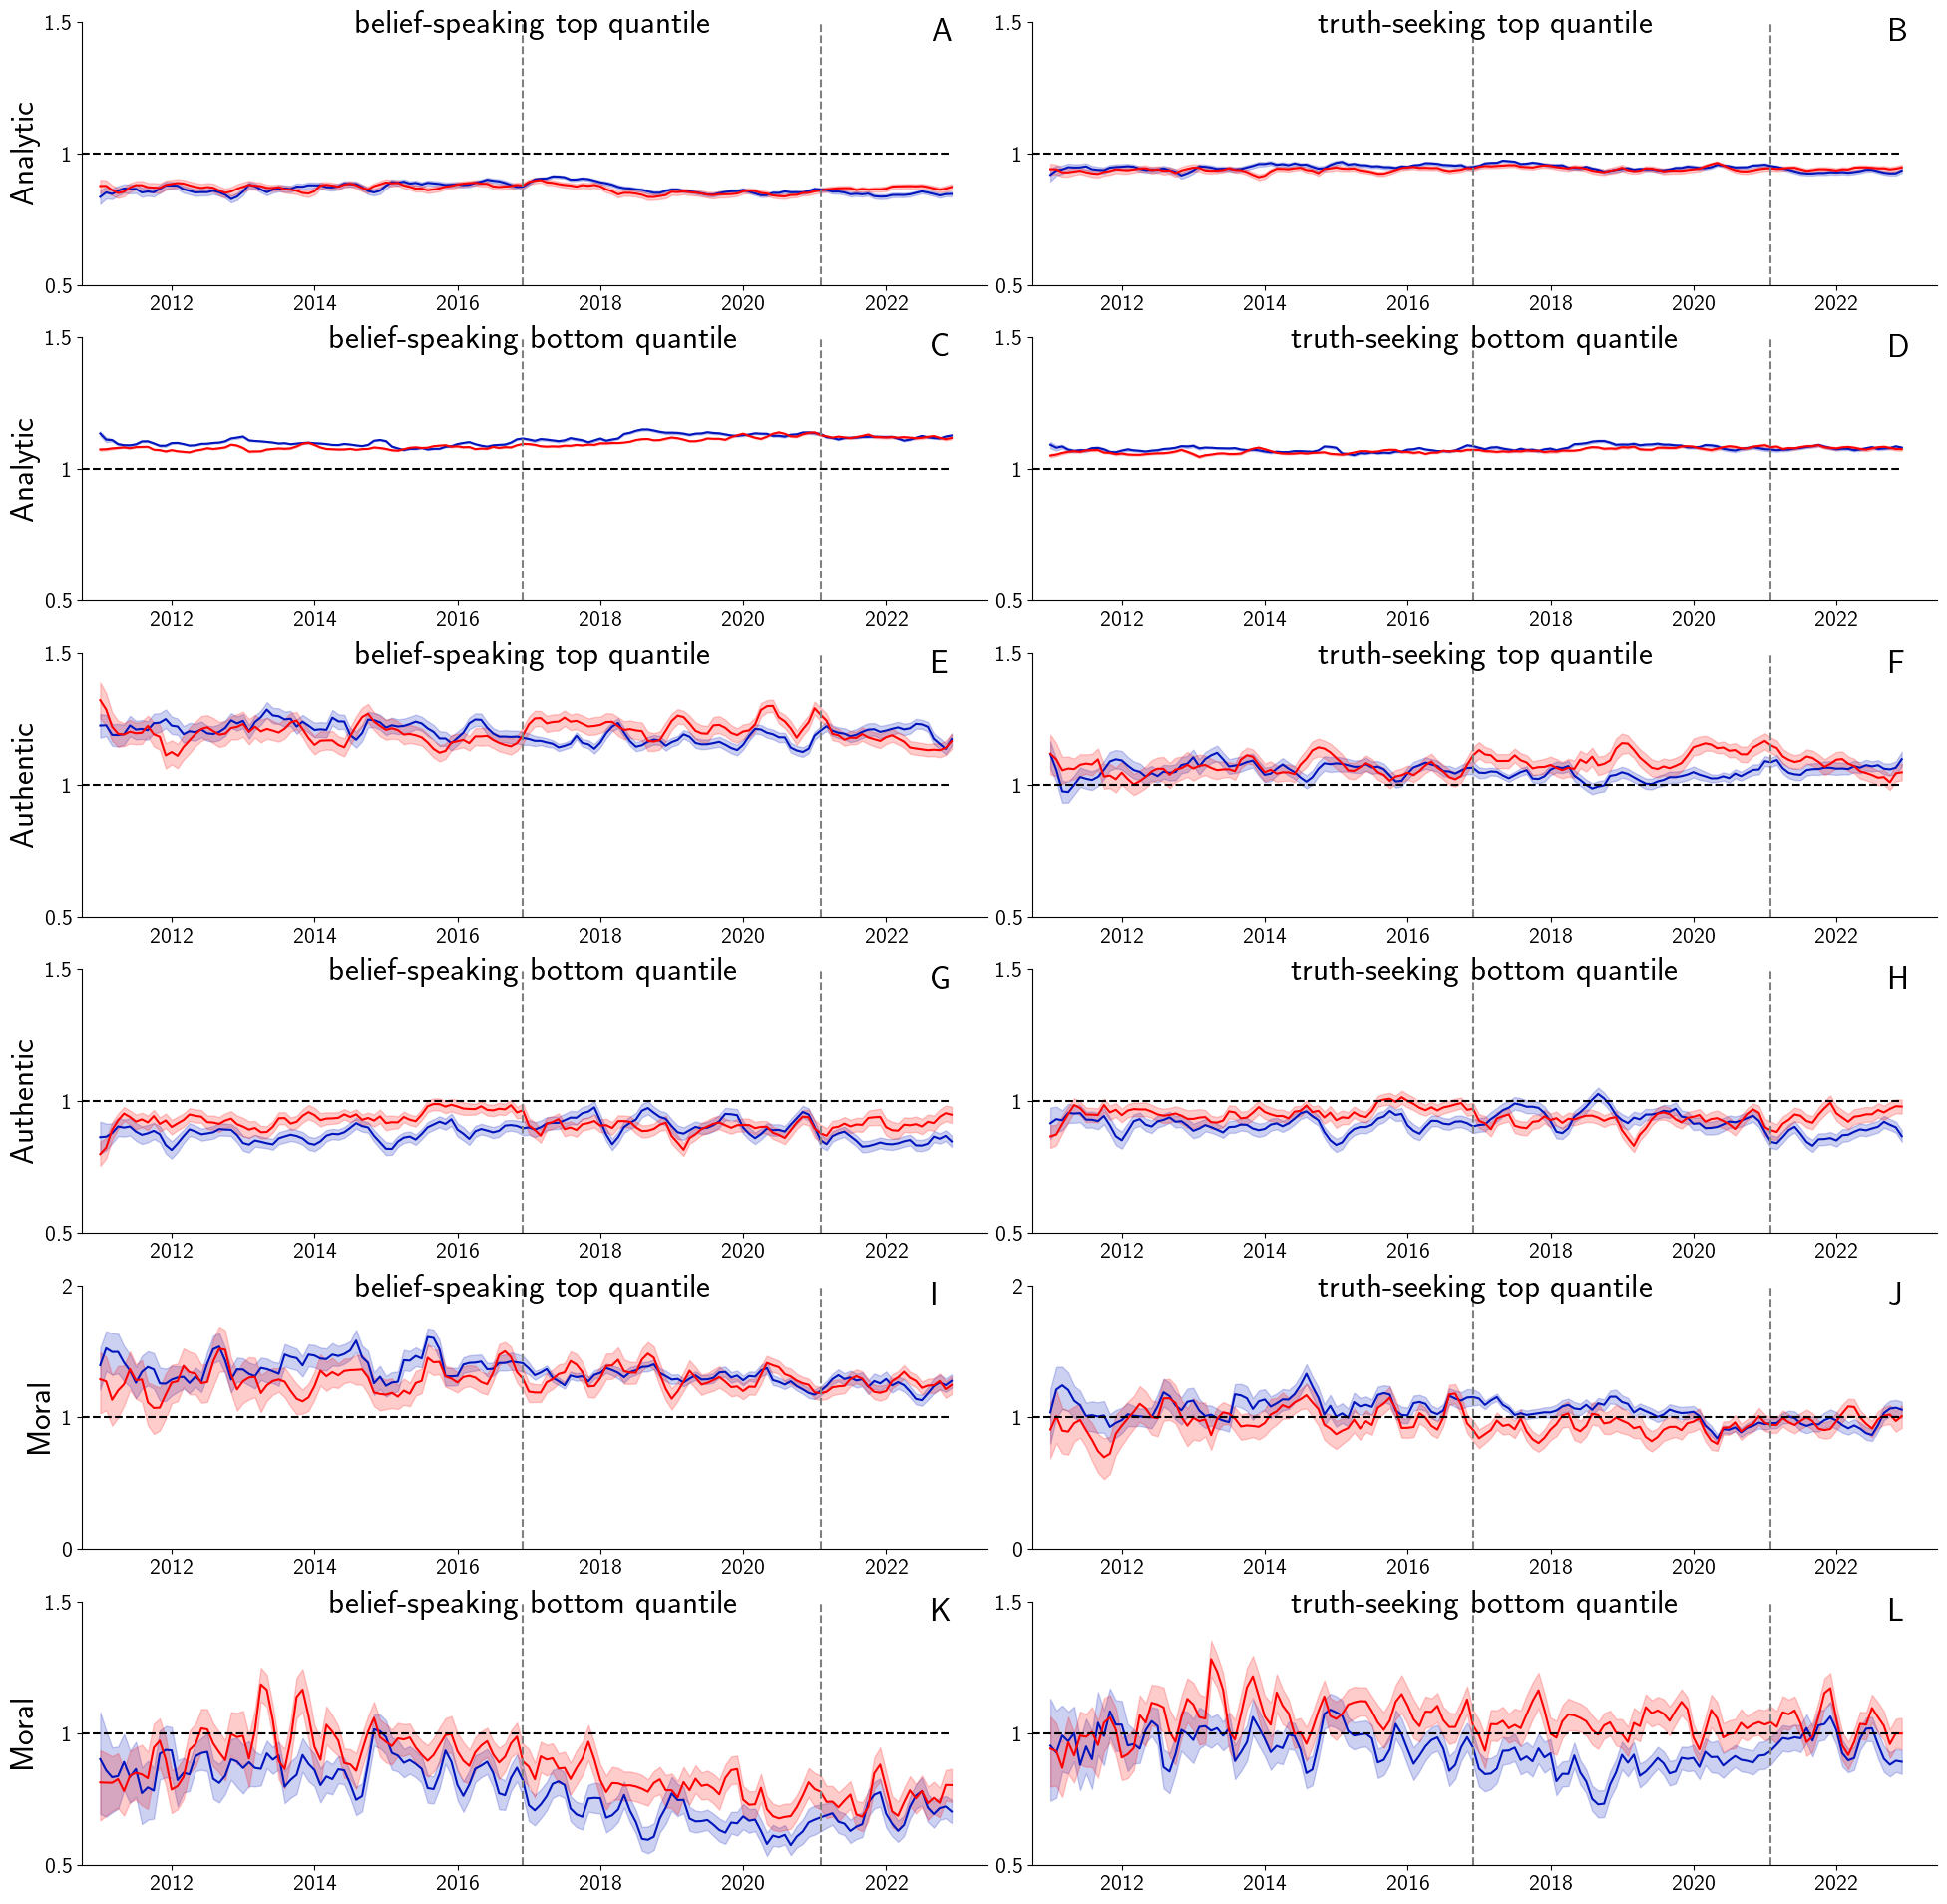

In [28]:
fname = "SI_fig8"
alpha = 0.2

fig = plt.figure(figsize=(24, 24))

gs = GridSpec(12, 2, figure=fig, hspace=0.5, wspace=0.05)
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[0:2, 1])
ax3 = fig.add_subplot(gs[2:4, 0])
ax4 = fig.add_subplot(gs[2:4, 1])

ax5 = fig.add_subplot(gs[4:6, 0])
ax6 = fig.add_subplot(gs[4:6, 1])
ax7 = fig.add_subplot(gs[6:8, 0])
ax8 = fig.add_subplot(gs[6:8, 1])

ax9 = fig.add_subplot(gs[8:10, 0])
ax10 = fig.add_subplot(gs[8:10, 1])
ax11 = fig.add_subplot(gs[10:, 0])
ax12 = fig.add_subplot(gs[10:, 1])

 
data = {
    "belief-speaking":LIWC_belief,
    "truth-seeking":LIWC_truth,
    "neutral_belief":LIWC_neutral_belief,
    "neutral_truth":LIWC_neutral_truth,
    "baseline":LIWC
}

ylims = {
    "LIWC_analytic_share":[0.5, 1.5],
    "LIWC_authentic_share":[0.5, 1.5],
    "LIWC_moral_share":[0, 2]
}

# analytic
plot_component(
    ax1, data["belief-speaking"], "belief-speaking top quantile", 
    data["baseline"], "LIWC_analytic_share", ylims["LIWC_analytic_share"],
    years=True
    )
plot_component(
    ax2, data["truth-seeking"], "truth-seeking top quantile", data["baseline"],
    "LIWC_analytic_share", ylims["LIWC_analytic_share"], years=True
)
plot_component(
    ax3, data["neutral_belief"], "belief-speaking bottom quantile", 
    data["baseline"], "LIWC_analytic_share", ylims["LIWC_analytic_share"],
    years=True
)
plot_component(
    ax4, data["neutral_truth"], "truth-seeking bottom quantile", 
    data["baseline"], "LIWC_analytic_share", ylims["LIWC_analytic_share"],
    years=True
)

# authentic
plot_component(
    ax5, data["belief-speaking"], "belief-speaking top quantile", 
    data["baseline"], "LIWC_authentic_share", ylims["LIWC_authentic_share"],
    years=True
)
plot_component(
    ax6, data["truth-seeking"], "truth-seeking top quantile", data["baseline"],
    "LIWC_authentic_share", ylims["LIWC_authentic_share"], years=True
)
plot_component(
    ax7, data["neutral_belief"], "belief-speaking bottom quantile", 
    data["baseline"], "LIWC_authentic_share", ylims["LIWC_authentic_share"],
    years=True
)
plot_component(
    ax8, data["neutral_truth"], "truth-seeking bottom quantile", 
    data["baseline"], "LIWC_authentic_share", ylims["LIWC_authentic_share"],
    years=True
)

# moral
plot_component(
    ax9, data["belief-speaking"], "belief-speaking top quantile", 
    data["baseline"], "LIWC_moral_share", ylims["LIWC_moral_share"],
    yticks=[0, 1, 2], years=True
)
plot_component(
    ax10, data["truth-seeking"], "truth-seeking top quantile", data["baseline"],
    "LIWC_moral_share", ylims["LIWC_moral_share"], yticks=[0, 1, 2],
    years=True
)
plot_component(
    ax11, data["neutral_belief"], "belief-speaking bottom quantile", 
    data["baseline"], "LIWC_moral_share", [0.5, 1.5], years=True
)
plot_component(
    ax12, data["neutral_truth"], "truth-seeking bottom quantile", 
    data["baseline"], "LIWC_moral_share", [0.5, 1.5], years=True
)


ax1.set_ylabel("Analytic", fontsize=24)
ax3.set_ylabel("Analytic", fontsize=24)
ax5.set_ylabel("Authentic", fontsize=24)
ax7.set_ylabel("Authentic", fontsize=24)
ax9.set_ylabel("Moral", fontsize=24)
ax11.set_ylabel("Moral", fontsize=24)

fig.text(0.48, 0.872, "A", fontsize=24)
fig.text(0.88, 0.872, "B", fontsize=24)
fig.text(0.48, 0.740, "C", fontsize=24)
fig.text(0.88, 0.740, "D", fontsize=24)
fig.text(0.48, 0.608, "E", fontsize=24)
fig.text(0.88, 0.608, "F", fontsize=24)
fig.text(0.48, 0.476, "G", fontsize=24)
fig.text(0.88, 0.476, "H", fontsize=24)
fig.text(0.48, 0.344, "I", fontsize=24)
fig.text(0.88, 0.344, "J", fontsize=24)
fig.text(0.48, 0.212, "K", fontsize=24)
fig.text(0.88, 0.212, "L", fontsize=24)

plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Fig 9: Party-topic breakdowns

In [64]:
# load topic labels for all tweets
fname = "topics_all_docs.csv.gzip"
topics = pd.read_csv(
    join(src, "tweets", fname),
    compression="gzip",
    dtype={"id":str},
)

In [66]:
# calculate corpus similarity averages
avg_belief = topics["avg_belief"].mean()
avg_truth = topics["avg_truth"].mean()
# calculate within-party corpus similarity averages
avg_belief_dem = topics[topics["party"] == "Democrat"]["avg_belief"].mean()
avg_belief_rep = topics[topics["party"] == "Republican"]["avg_belief"].mean()
avg_truth_dem = topics[topics["party"] == "Democrat"]["avg_truth"].mean()
avg_truth_rep = topics[topics["party"] == "Republican"]["avg_truth"].mean()

In [67]:
# retain only the topics of interest
chosen_topics = [4, 3, 26, 7, 12, 64, 15, 33, 31, 19, 10, 21, 37, 0, 35,
                 17, 143, 149, 225, 293]
topics = topics[topics["topic"].isin(chosen_topics)]

In [68]:
# merge with topic names
fname = "topics_per_class_ddr.csv"
topic_names = pd.read_csv(join(src, "tweets", fname))\
    .rename(columns={"Topic":"topic", "Name":"name"})
topics = pd.merge(
    topics,
    topic_names[["topic", "name"]].drop_duplicates(),
    how="left",
    left_on="topic",
    right_on="topic"
)
del topic_names

In [69]:
# beautify the topic name strings
topics["name"] = topics["name"].apply(lambda x: x.split("_"))
topics["name"] = topics["name"].apply(lambda x: " $\\vert$ ".join(x[1:]))

In [70]:
# calculate similarity differences
topics["avg_belief_norm"] = topics["avg_belief"] - avg_belief
topics["avg_truth_norm"] = topics["avg_truth"] - avg_truth

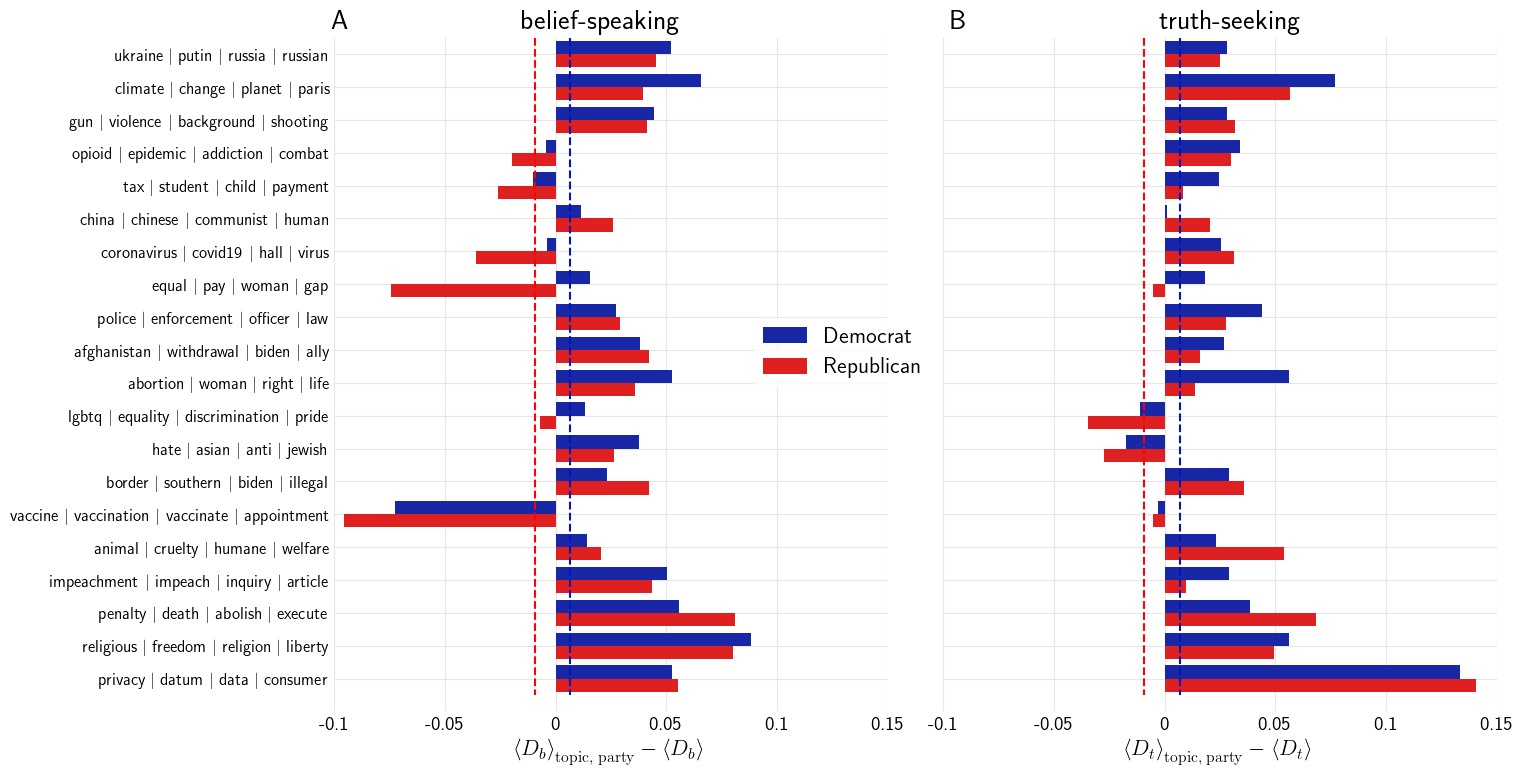

In [71]:
# set up figure and subplots
fname = "SI_fig9"
fig = plt.figure(figsize=(15, 8.75))
gs = GridSpec(7, 2, figure=fig, hspace=0.8, wspace=0.1)
ax1 = fig.add_subplot(gs[0:, 0])
ax2 = fig.add_subplot(gs[0:, 1])
axes = [ax1, ax2]

# belief-speaking
sns.barplot(x="avg_belief_norm", 
            y="name",
            hue="party",
            data=topics,
            ax=axes[0],
            palette=[demblue, repred], 
            hue_order=["Democrat", "Republican"],
            zorder=3,
            ci=None)
# truth-seeking
sns.barplot(x="avg_truth_norm", 
            y="name",
            hue="party",
            data=topics,
            ax=axes[1],
            palette=[demblue, repred], 
            hue_order=["Democrat", "Republican"],
            zorder=3,
            ci=None)

# axis labels, ticks, annotations and grids
ax1.tick_params(axis='y', labelsize=12)

ax2.set_xlabel("")
ax2.legend_.remove()
ax1.set_xlabel("$\\left<D_b\\right>_\\mathrm{topic,\;party} - \\left<D_b\\right>$", fontsize=16)
ax2.set_xlabel("$\\left<D_t\\right>_\\mathrm{topic,\;party} - \\left<D_t\\right>$", fontsize=16)

legend = ax1.legend(loc=1, bbox_to_anchor=[1.1, 0.6, 0, 0], fontsize=16)
legend.get_frame().set_facecolor((1, 1, 1, 1))
legend.get_frame().set_edgecolor((1, 1, 1, 1))

 
ax1.set_xlim(-0.1, 0.15)
ax1.set_xticks([-0.1, -0.05, 0, 0.05, 0.1, 0.15])
ax1.set_xticklabels([-0.1, -0.05, 0, 0.05, 0.1, 0.15], fontsize=14)
ax2.set_xlim(-0.1, 0.15)
ax2.set_xticks([-0.1, -0.05, 0, 0.05, 0.1, 0.15])
ax2.set_xticklabels([-0.1, -0.05, 0, 0.05, 0.1, 0.15], fontsize=14)

ax2.set_yticklabels([])

# mean corpus lines
ax1.plot([avg_belief_dem - avg_belief, avg_belief_dem - avg_belief], [-0.5, len(chosen_topics) - 0.5],
         '--', color=demblue, zorder=4)
ax1.plot([avg_belief_rep - avg_belief, avg_belief_rep - avg_belief], [-0.5, len(chosen_topics) - 0.5],
         '--', color=repred, zorder=4)
ax2.plot([avg_truth_dem - avg_truth, avg_truth_dem - avg_truth], [-0.5, len(chosen_topics) - 0.5],
         '--', color=demblue, zorder=4)
ax2.plot([avg_truth_rep - avg_truth, avg_truth_rep - avg_truth], [-0.5, len(chosen_topics) - 0.5],
         '--', color=repred, zorder=4)
    
for ax in axes:
    ax.set_ylabel("")
    ax.set_ylim(len(chosen_topics), -0.5)
    ax.grid(which="both", zorder=1, color=(230/255, 230/255, 230/255))
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    
fig.text(0.123, 0.89, "A", fontsize=20)
fig.text(0.25, 0.89, "belief-speaking", fontsize=20)
fig.text(0.536, 0.89, "B", fontsize=20)
fig.text(0.675, 0.89, "truth-seeking", fontsize=20)

plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Fig 10: Individual state stats

In [41]:
fname = "users.csv"
users = pd.read_csv(join(src, "users", fname))
users = users[users["party"].isin(["Democrat", "Republican"])]
dem = users[users["party"] == "Democrat"]
rep = users[users["party"] == "Republican"]

In [42]:
agg_belief_dem = dem[["state", "avg_belief_score", "NG_score_mean"]]\
    .groupby(by="state")\
    .agg("mean")
agg_belief_dem = agg_belief_dem\
    .reset_index()\
    .sort_values(by="avg_belief_score")\
    .reset_index(drop=True)

agg_truth_dem = dem[["state", "avg_truth_score", "NG_score_mean"]]\
    .groupby(by="state")\
    .agg("mean")
agg_truth_dem = agg_truth_dem\
    .reset_index()\
    .sort_values(by="avg_truth_score")\
    .reset_index(drop=True)

agg_belief_rep = rep[["state", "avg_belief_score", "NG_score_mean"]]\
    .groupby(by="state")\
    .agg("mean")
agg_belief_rep = agg_belief_rep\
    .reset_index()\
    .sort_values(by="avg_belief_score")\
    .reset_index(drop=True)

agg_truth_rep = rep[["state", "avg_truth_score", "NG_score_mean"]]\
    .groupby(by="state")\
    .agg("mean")
agg_truth_rep = agg_truth_rep\
    .reset_index()\
    .sort_values(by="avg_truth_score")\
    .reset_index(drop=True)

In [43]:
state_names = pd.read_csv(
    join(src, "utilities", "state_names.csv"),
    usecols=["code", "state"]
).rename(columns={"code":"state", "state":"state_name"})

In [44]:
agg_belief_dem = pd.merge(
    agg_belief_dem,
    state_names,
    how="left",
    left_on="state",
    right_on="state"
).dropna()

agg_truth_dem = pd.merge(
    agg_truth_dem,
    state_names,
    how="left",
    left_on="state",
    right_on="state"
).dropna()

agg_belief_rep = pd.merge(
    agg_belief_rep,
    state_names,
    how="left",
    left_on="state",
    right_on="state"
).dropna()

agg_truth_rep = pd.merge(
    agg_truth_rep,
    state_names,
    how="left",
    left_on="state",
    right_on="state"
).dropna()

In [45]:
votes = pd.read_csv(
    join(src, "utilities", "popular_vote_2020.csv"),
    usecols=["stateid", "dem_percent", "rep_percent", "called"]
).rename(columns={"stateid":"state"})
votes["dem_percent"] = votes["dem_percent"].apply(lambda x: float(x.replace("%", "")) / 100)
votes["rep_percent"] = votes["rep_percent"].apply(lambda x: float(x.replace("%", "")) / 100)

In [46]:
agg_belief_dem = pd.merge(
    agg_belief_dem,
    votes[["state", "dem_percent", "called"]],
    how="left",
    left_on="state",
    right_on="state"
).dropna().rename(columns={"dem_percent":"vote"})

agg_truth_dem = pd.merge(
    agg_truth_dem,
    votes[["state", "dem_percent", "called"]],
    how="left",
    left_on="state",
    right_on="state"
).dropna().rename(columns={"dem_percent":"vote"})

agg_belief_rep = pd.merge(
    agg_belief_rep,
    votes[["state", "rep_percent", "called"]],
    how="left",
    left_on="state",
    right_on="state"
).dropna().rename(columns={"rep_percent":"vote"})

agg_truth_rep = pd.merge(
    agg_truth_rep,
    votes[["state", "rep_percent", "called"]],
    how="left",
    left_on="state",
    right_on="state"
).dropna().rename(columns={"rep_percent":"vote"})

In [47]:
southern_states = ["AL", "AR", "GA", "LA", "MS", "NC", "SC", "TN", "VA", "TX", "FL", "OK"]
northern_states = ["ME", "NY", "NH", "MA", "CT", "RI", "PA", "NJ", "OH", "IN", "IL", "KS", "MI", "WI", "MN", "IA", "CA", "NV", "OR"]

In [48]:
agg_truth_rep = agg_truth_rep.set_index("state")

In [49]:
agg_truth_dem = agg_truth_dem.set_index("state")

In [50]:
agg_truth_rep.loc[southern_states, "NG_score_mean"] - agg_truth_rep["NG_score_mean"].mean()

state
AL   -5.153871
AR    2.415352
GA   -1.992860
LA   -0.384896
MS   -1.558699
NC   -2.225041
SC   -1.149475
TN   -3.004259
VA   -1.778132
TX   -2.392304
FL   -2.966351
OK   -1.271109
Name: NG_score_mean, dtype: float64

In [51]:
agg_truth_dem.loc[southern_states, "NG_score_mean"] - agg_truth_dem["NG_score_mean"].mean()

state
AL   -0.279260
AR   -0.070954
GA   -0.204493
LA   -2.744463
MS   -0.242387
NC    0.478641
SC    2.018545
TN    0.154883
VA   -1.391846
TX    0.796066
FL    0.382535
OK    0.751545
Name: NG_score_mean, dtype: float64

In [52]:
agg_truth_rep.loc[["ME", "NY", "NH", "PA", "NJ", "OH", "IN", "IL", "KS", "MI", "WI", "MN", "IA", "CA", "NV", "OR"], "NG_score_mean"] - agg_truth_rep["NG_score_mean"].mean()

state
ME    7.755880
NY   -3.797430
NH    7.330330
PA   -0.715108
NJ   -6.039008
OH    0.546405
IN   -0.583818
IL   -1.789856
KS   -0.460319
MI    1.921854
WI    0.374305
MN    1.094811
IA   -0.656028
CA   -2.009710
NV    3.224923
OR    1.813311
Name: NG_score_mean, dtype: float64

In [53]:
agg_truth_dem.loc[northern_states, "NG_score_mean"] - agg_truth_dem["NG_score_mean"].mean()

state
ME    2.514569
NY   -0.728114
NH    2.070265
MA   -0.704369
CT   -0.692845
RI   -1.334506
PA   -0.459231
NJ    1.879425
OH   -0.174208
IN   -4.461736
IL   -0.237755
KS    0.210533
MI    0.623243
WI   -0.828701
MN    1.462411
IA   -1.494203
CA    0.467507
NV   -0.649405
OR    0.909984
Name: NG_score_mean, dtype: float64

In [54]:
agg_truth_dem = agg_truth_dem.reset_index()
agg_truth_rep = agg_truth_rep.reset_index()

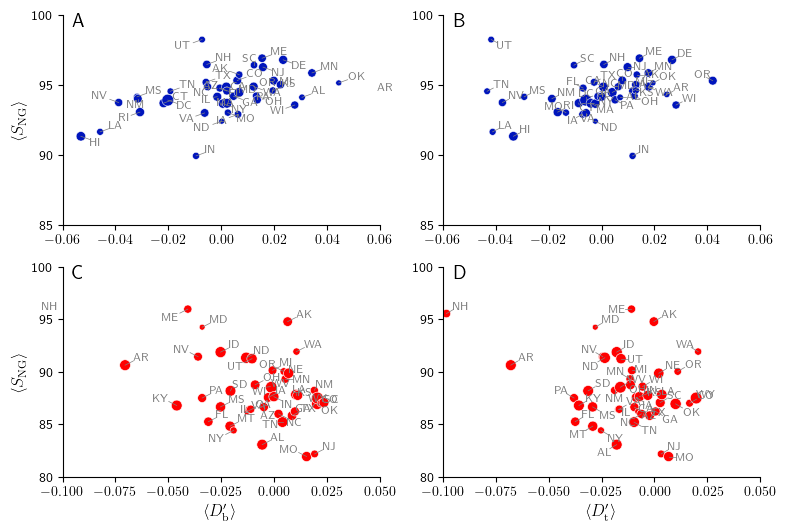

In [55]:
fname = "SI_fig10"
fig, axes = plt.subplots(2, 2, figsize=(9, 6))
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

for ax, df, color in zip([ax1, ax3], [agg_belief_dem, agg_belief_rep], [demblue, repred]):
    df["vote_scaled"] = df["vote"] * 100 
    sns.scatterplot(
        x="avg_belief_score",
        y="NG_score_mean",
        size="vote_scaled",
        data=df,
        color=color,
        ax=ax,
        legend=False
    )
    ta.allocate_text(
        fig, ax, 
        df["avg_belief_score"],
        df["NG_score_mean"],
        df["state"],
        x_scatter=df["avg_belief_score"],
        y_scatter=df["NG_score_mean"],
        max_distance=0.05,
        min_distance=0.025,
        linewidth=0.5,
        textsize=8,
        linecolor="grey",
        textcolor="grey",
        nbr_candidates=500
    )
    
for ax, df, color in zip([ax2, ax4], [agg_truth_dem, agg_truth_rep], [demblue, repred]):
    df["vote_scaled"] = df["vote"] * 100
    sns.scatterplot(
        x="avg_truth_score",
        y="NG_score_mean",
        size="vote_scaled",
        data=df,
        color=color,
        ax=ax,
        legend=False
    )
    ta.allocate_text(
        fig, ax, 
        df["avg_truth_score"],
        df["NG_score_mean"],
        df["state"],
        x_scatter=df["avg_truth_score"],
        y_scatter=df["NG_score_mean"],
        max_distance=0.05,
        min_distance=0.025,
        linewidth=0.5,
        textsize=8,
        linecolor="grey",
        textcolor="grey",
        nbr_candidates=500
    )
   
ax1.set_xlim(-0.06, 0.06)
ax1.set_xticks([-0.06, -0.04, -0.02, 0.0, 0.02, 0.04, 0.06])
ax1.set_xlabel("")
ax2.set_xlim(-0.06, 0.06)
ax2.set_xticks([-0.06, -0.04, -0.02, 0.0, 0.02, 0.04, 0.06])
ax2.set_xlabel("")
ax3.set_xlim(-0.1, 0.05)
ax4.set_xlim(-0.1, 0.05)

yticks = range(85, 101, 5)
for ax in [ax1, ax2]:
    ax.set_ylim(85, 100)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)
yticks = range(80, 101, 5)
for ax in [ax3, ax4]:
    ax.set_ylim(80, 100)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)

ax3.set_xlabel("$\\left<D'_\\mathrm{b}\\right>$", fontsize=12)
ax4.set_xlabel("$\\left<D'_\\mathrm{t}\\right>$", fontsize=12)
for ax in [ax2, ax4]:
    ax.set_ylabel("")
for ax in [ax1, ax2, ax3, ax4]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

for ax in [ax1, ax3]:
    ax.set_ylabel("$\\left<S_\\mathrm{NG}\\right>$", fontsize=12)
for ax in [ax1, ax2]:
    ax.set_xlabel("")

fig.text(0.135, 0.86, "A", fontsize=14)
fig.text(0.56, 0.86, "B", fontsize=14)
fig.text(0.135, 0.44, "C", fontsize=14)
fig.text(0.56, 0.44, "D", fontsize=14)

plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

In [56]:
agg_belief_dem[["NG_score_mean", "called"]].groupby(by=["called"]).mean()

NG_score_mean
called               
D           94.487105
R           94.215608

In [57]:
agg_belief_rep[["NG_score_mean", "called"]].groupby(by=["called"]).mean()

NG_score_mean
called               
D           88.852931
R           87.707495

In [58]:
agg_belief_rep[["NG_score_mean", "vote"]].corr()

NG_score_mean      vote
NG_score_mean       1.000000 -0.115302
vote               -0.115302  1.000000

## Fig 11: One keyword similarity

In [5]:
fname = "combined_US_politician_twitter_timelines_2010-11-06_to_2022-12-31_honesty_component_scores_glove_singleword.csv.gzip"
cols = ["id", "author_id", "created_at"]
cols = cols + [f"avg_belief_score_{i}" for i in range(37)]
cols = cols + [f"avg_truth_score_{i}" for i in range(37)]
scores = pd.read_csv(
    join(src, "tweets", fname),
    compression="gzip",
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at"],
    usecols=cols,
)

In [6]:
fname = "US_politician_tweets_2010-11-06_to_2022-12-31.csv.gzip"
parties = pd.read_csv(
    join(src, "tweets", fname),
    compression="gzip",
    usecols=["id", "party", "tweet_length"],
    dtype={"id":str}
)

In [7]:
fname = "truth_seeking_p=0.05_swapped_wn_def_example.csv"
truth_keywords = list(pd.read_csv(join(src, "utilities", fname))["truth_seeking"].values)
fname = "belief_speaking_p=0.05_swapped_wn_def_example.csv"
belief_keywords = list(pd.read_csv(join(src, "utilities", fname))["belief_speaking"].values)

In [8]:
scores = scores.merge(parties)

In [9]:
from scipy.stats import linregress

In [ ]:
subset = scores.dropna()
for i in range(37):
    print(i)
    slope_belief, intercept_belief, rval_belief, pval_belief, stderr_belief = \
    linregress(subset["tweet_length"], subset[f"avg_belief_score_{i}"])
    print(f"belief-speaking slope: {slope_belief}, intercept: {intercept_belief}")

    def predict_belief_similarity(tweet_length):
        return intercept_belief + slope_belief * tweet_length

    slope_truth, intercept_truth, rval_truth, pval_truth, stderr_truth = \
        linregress(subset["tweet_length"], subset[f"avg_truth_score_{i}"])
    print(f"truth-seeking slope: {slope_truth}, intercept: {intercept_truth}")

    def predict_truth_similarity(tweet_length):
        return intercept_truth + slope_truth * tweet_length

    scores[f"avg_belief_score_{i}"] = scores\
        .apply(lambda x: x[f"avg_belief_score_{i}"] - predict_belief_similarity(x["tweet_length"]), axis=1)    
    scores[f"avg_truth_score_{i}"] = scores\
        .apply(lambda x: x[f"avg_truth_score_{i}"] - predict_truth_similarity(x["tweet_length"]), axis=1)


In [11]:
scores = scores[scores["party"].isin(["Democrat", "Republican"])]

In [12]:
cols = ["id", "author_id", "created_at", "party"]
belief_scores = scores[cols + [f"avg_belief_score_{i}" for i in range(37)]]
belief_scores.columns = cols + belief_keywords

truth_scores = scores[cols + [f"avg_truth_score_{i}" for i in range(37)]]
truth_scores.columns = cols + truth_keywords

In [13]:
belief_scores = belief_scores.set_index("created_at")
truth_scores = truth_scores.set_index("created_at")

In [14]:
changes = pd.DataFrame()
early = belief_scores[belief_scores.index.year <= 2013]
late = belief_scores[belief_scores.index.year >= 2019]
for keyword in belief_keywords:
    row = pd.DataFrame({
        "component":["belief"],
        "keyword":[keyword],
        "2010_to_2013":[early[keyword].mean()],
        "2019_to_2022":[late[keyword].mean()],
    })
    changes = pd.concat([changes, row])

early = truth_scores[truth_scores.index.year <= 2013]
late = truth_scores[truth_scores.index.year >= 2019]
for keyword in truth_keywords:
    row = pd.DataFrame({
        "component":["truth"],
        "keyword":[keyword],
        "2010_to_2013":[early[keyword].mean()],
        "2019_to_2022":[late[keyword].mean()],
    })
    changes = pd.concat([changes, row])
    
changes["diff"] = changes["2019_to_2022"] - changes["2010_to_2013"]
changes["diff_perc"] = (changes["diff"] / np.abs(changes["2010_to_2013"])) * 100

In [15]:
changes[changes["component"] == "belief"].sort_values(by=["diff"], ascending=False)[0:10]

component    keyword  2010_to_2013  2019_to_2022      diff   diff_perc
0    belief     surely     -0.029680      0.009815  0.039495  133.068866
0    belief       seem     -0.026813      0.009634  0.036447  135.928179
0    belief       feel     -0.026600      0.009344  0.035945  135.128720
0    belief  obviously     -0.025723      0.009353  0.035076  136.361068
0    belief    obvious     -0.025033      0.008652  0.033686  134.562915
0    belief    believe     -0.024962      0.008396  0.033358  133.634294
0    belief  genuinely     -0.025993      0.007147  0.033140  127.495226
0    belief  virtually     -0.024744      0.007532  0.032276  130.439311
0    belief   probably     -0.023010      0.009254  0.032264  140.218646
0    belief  basically     -0.023146      0.009081  0.032226  139.231831

In [16]:
changes[changes["component"] == "truth"].sort_values(by=["diff"], ascending=False)[0:10]

component    keyword  2010_to_2013  2019_to_2022      diff   diff_perc
0     truth       fact     -0.028592      0.009323  0.037915  132.607930
0     truth   actually     -0.024766      0.009546  0.034312  138.545606
0     truth      prove     -0.025197      0.007684  0.032881  130.496582
0     truth      truth     -0.022977      0.007627  0.030604  133.195613
0     truth    observe     -0.022363      0.005420  0.027784  124.236686
0     truth    reality     -0.020957      0.006796  0.027753  132.428266
0     truth       real     -0.019806      0.006970  0.026776  135.188482
0     truth    correct     -0.018055      0.007218  0.025273  139.977860
0     truth  determine     -0.019401      0.005173  0.024573  126.663769
0     truth      proof     -0.017869      0.006242  0.024111  134.935018

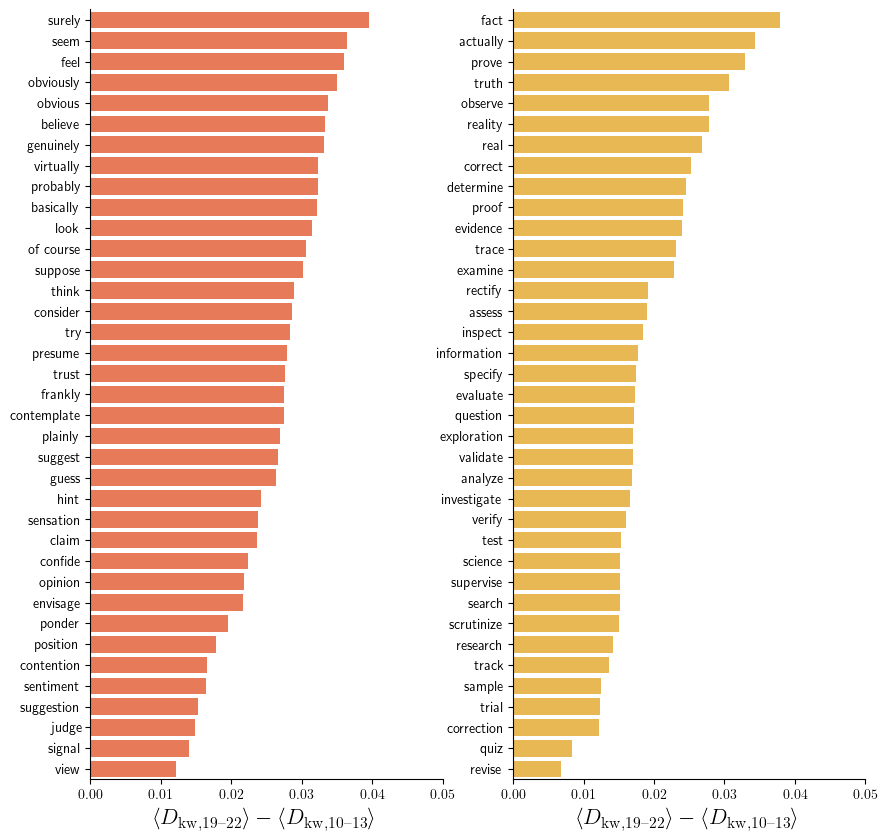

In [17]:
fname = "SI_fig11"
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
subset = changes[changes["component"] == "belief"].sort_values(by=["diff"], ascending=False)
sns.barplot(
    data=subset, 
    x="diff", 
    y="keyword",
    ax=axes[0],
    color=orange
)
subset = changes[changes["component"] == "truth"].sort_values(by=["diff"], ascending=False)
sns.barplot(
    data=subset, 
    x="diff", 
    y="keyword",
    ax=axes[1],
    color=yellow
)

for ax in axes:
    ax.set_ylabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("$\\left<D_\\mathrm{kw, 19–22}\\right> - \\left<D_\\mathrm{kw, 10–13}\\right>$", fontsize=16)
    ax.set_xlim(0, 0.05)
    
plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

# Additional plots

## State honesty component rankings

In [96]:
fname = "users.csv"
users = pd.read_csv(join(src, "users", fname))
users = users[users["party"].isin(["Democrat", "Republican"])]
dem = users[users["party"] == "Democrat"]
rep = users[users["party"] == "Republican"]

In [97]:
agg_belief = users[["state", "avg_belief_score", "NG_score_mean"]]\
    .groupby(by="state")\
    .agg("mean")
agg_belief = agg_belief\
    .reset_index()\
    .sort_values(by="avg_belief_score")\
    .reset_index(drop=True)

agg_truth = users[["state", "avg_truth_score", "NG_score_mean"]]\
    .groupby(by="state")\
    .agg("mean")
agg_truth = agg_truth\
    .reset_index()\
    .sort_values(by="avg_truth_score")\
    .reset_index(drop=True)

In [98]:
state_names = pd.read_csv(
    join(src, "utilities", "state_names.csv"),
    usecols=["code", "state"]
).rename(columns={"code":"state", "state":"state_name"})

In [99]:
agg_belief = pd.merge(
    agg_belief,
    state_names,
    how="left",
    left_on="state",
    right_on="state"
).dropna()

agg_truth = pd.merge(
    agg_truth,
    state_names,
    how="left",
    left_on="state",
    right_on="state"
).dropna()

/tmp/ipykernel_1190536/1294351930.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


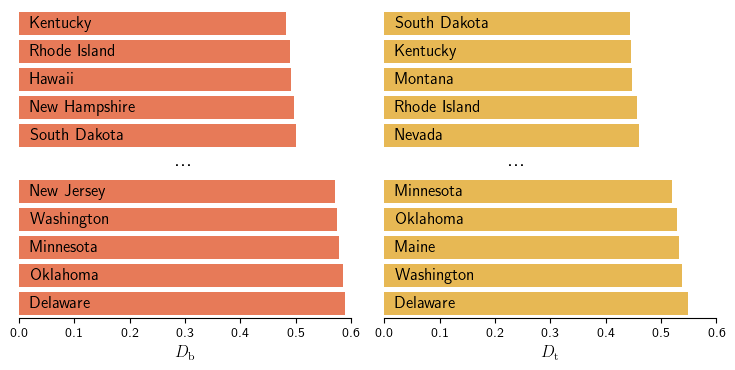

In [100]:
fname = "state_honesty_component_ranking"
fig = plt.figure(figsize=(9, 4))

gs = GridSpec(2, 2, figure=fig, hspace=0.2, wspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

sns.barplot(x="avg_belief_score", 
            y="state",
            data=agg_belief[0:5],
            ax=ax1,
            color=orange,
            ci=None)
for i, state in enumerate(agg_belief["state_name"][0:5]):
    ax1.text(0.02, i + 0.16, state, fontsize=12)

sns.barplot(x="avg_belief_score", 
            y="state",
            data=agg_belief[-5:],
            ax=ax3,
            color=orange,
            ci=None)
for i, state in enumerate(agg_belief["state_name"][-5:]):
    ax3.text(0.02, i + 0.16, state, fontsize=12)

sns.barplot(x="avg_truth_score", 
            y="state",
            data=agg_truth[0:5],
            ax=ax2,
            color=yellow,
            ci=None)
for i, state in enumerate(agg_truth["state_name"][0:5]):
    ax2.text(0.02, i + 0.16, state, fontsize=12)
    
sns.barplot(x="avg_truth_score", 
            y="state",
            data=agg_truth[-5:],
            ax=ax4,
            color=yellow,
            ci=None)
for i, state in enumerate(agg_truth["state_name"][-5:]):
    ax4.text(0.02, i + 0.16, state, fontsize=12)
    
for ax in [ax1, ax2, ax3, ax4]:
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_xlim(0, 0.6)
    ax.set_yticks([])

for ax in [ax1, ax2]:
    ax.spines['bottom'].set_visible(False)    

xticks = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
for ax in [ax3, ax4]:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    
fig.text(0.3, 0.49, "...", fontsize=16)
fig.text(0.67, 0.49, "...", fontsize=16)
ax3.set_xlabel("$D_\\mathrm{b}$", fontsize=12)
ax4.set_xlabel("$D_\\mathrm{t}$", fontsize=12)
fig.tight_layout()
#plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
#plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
#plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Account honesty component rankings

In [101]:
fname = "users.csv"
users = pd.read_csv(join(src, "users", fname))
users = users[users["party"].isin(["Democrat", "Republican"])]
dem = users[users["party"] == "Democrat"]
rep = users[users["party"] == "Republican"]

In [102]:
agg_belief = users[["state", "avg_belief_score", "NG_score_mean"]]\
    .groupby(by="state")\
    .agg("mean")
agg_belief = agg_belief\
    .reset_index()\
    .sort_values(by="avg_belief_score")\
    .reset_index(drop=True)

agg_truth = users[["state", "avg_truth_score", "NG_score_mean"]]\
    .groupby(by="state")\
    .agg("mean")
agg_truth = agg_truth\
    .reset_index()\
    .sort_values(by="avg_truth_score")\
    .reset_index(drop=True)

In [103]:
state_names = pd.read_csv(
    join(src, "utilities", "state_names.csv"),
    usecols=["code", "state"]
).rename(columns={"code":"state", "state":"state_name"})

In [104]:
agg_belief = pd.merge(
    agg_belief,
    state_names,
    how="left",
    left_on="state",
    right_on="state"
).dropna()

agg_truth = pd.merge(
    agg_truth,
    state_names,
    how="left",
    left_on="state",
    right_on="state"
).dropna()

/tmp/ipykernel_1190536/50051889.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


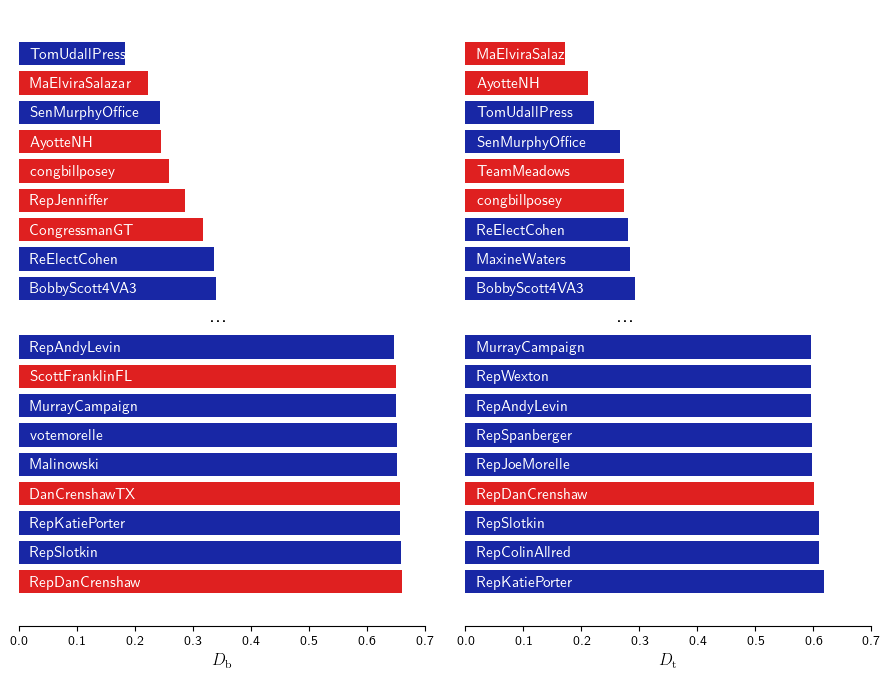

In [105]:
fname = "account_honesty_component_ranking"
N = 10
fig = plt.figure(figsize=(11, 0.8*N))

gs = GridSpec(2, 2, figure=fig, hspace=0.1, wspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

users_belief = users[["avg_belief_score", "handle", "party"]]\
    .sort_values(by="avg_belief_score").set_index("handle")
users_truth = users[["avg_truth_score", "handle", "party"]]\
    .sort_values(by="avg_truth_score").set_index("handle")
colors = {"Democrat":demblue, "Republican":repred}

palette = [colors[users_belief.loc[name, "party"]] for name in users_belief.index[0:N]]
sns.barplot(x="avg_belief_score", 
            y="handle",
            data=users_belief[0:N].reset_index(),
            ax=ax1,
            palette=palette,
            ci=None)
for i, name in enumerate(users_belief.index[0:N]):
    ax1.text(0.02, i + 0.16,name, fontsize=11, color="w")
    
palette = [colors[users_belief.loc[name, "party"]] for name in users_belief.index[-N:]]
sns.barplot(x="avg_belief_score", 
            y="handle",
            data=users_belief[-N:].reset_index(),
            ax=ax3,
            palette=palette,
            ci=None)
for i, name in enumerate(users_belief.index[-N:]):
    ax3.text(0.02, i + 0.16,name, fontsize=11, color="w")
    
palette = [colors[users_truth.loc[name, "party"]] for name in users_truth.index[0:N]]
sns.barplot(x="avg_truth_score", 
            y="handle",
            data=users_truth[0:N].reset_index(),
            ax=ax2,
            palette=palette,
            ci=None)
for i, name in enumerate(users_truth.index[0:N]):
    ax2.text(0.02, i + 0.16,name, fontsize=11, color="w")
    
palette = [colors[users_truth.loc[name, "party"]] for name in users_truth.index[-N:]]
sns.barplot(x="avg_truth_score", 
            y="handle",
            data=users_truth[-N:].reset_index(),
            ax=ax4,
            palette=palette,
            ci=None)
for i, name in enumerate(users_truth.index[-N:]):
    ax4.text(0.02, i + 0.16,name, fontsize=11, color="w")

    
for ax in [ax1, ax2, ax3, ax4]:
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_xlim(0, 0.7)
    ax.set_yticks([])

for ax in [ax1, ax2]:
    ax.spines['bottom'].set_visible(False)    

xticks = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
for ax in [ax3, ax4]:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    
fig.text(0.3, 0.49, "...", fontsize=16)
fig.text(0.67, 0.49, "...", fontsize=16)
ax3.set_xlabel("$D_\\mathrm{b}$", fontsize=12)
ax4.set_xlabel("$D_\\mathrm{t}$", fontsize=12)
fig.tight_layout()
#plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
#plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
#plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Correlation between trustworthiness indicators

In [106]:
fname = "users.csv"
users = pd.read_csv(join(src, "users", fname))

In [107]:
fname = "user_reliability_score_correlations.csv.gzip"
pf_bootstrap = pd.read_csv(join(src, "bootstrapping", fname), compression="gzip")

In [108]:
print("correlation NewsGuard Score with NewsGuard share: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGScore_NGShare"].mean(),
        pf_bootstrap["corr_NGScore_NGShare"].quantile(0.025),
        pf_bootstrap["corr_NGScore_NGShare"].quantile(0.975),))

print("correlation NewsGuard Share with politifact: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGShare_pf"].mean(),
        pf_bootstrap["corr_NGShare_pf"].quantile(0.025),
        pf_bootstrap["corr_NGShare_pf"].quantile(0.975),))

print("correlation NewsGuard Share with independent list: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGShare_ind"].mean(),
        pf_bootstrap["corr_NGShare_ind"].quantile(0.025),
        pf_bootstrap["corr_NGShare_ind"].quantile(0.975),))

print("correlation NewsGuard Score with politifact: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGScore_pf"].mean(),
        pf_bootstrap["corr_NGScore_pf"].quantile(0.025),
        pf_bootstrap["corr_NGScore_pf"].quantile(0.975),))

print("correlation independent list with politifact: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_ind_pf"].mean(),
        pf_bootstrap["corr_ind_pf"].quantile(0.025),
        pf_bootstrap["corr_ind_pf"].quantile(0.975),))

print("correlation NewsGuard Score with independent list: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGScore_ind"].mean(),
        pf_bootstrap["corr_NGScore_ind"].quantile(0.025),
        pf_bootstrap["corr_NGScore_ind"].quantile(0.975),))

print("correlation NewsGuard Score with accuracy score: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGScore_accuracy"].mean(),
        pf_bootstrap["corr_NGScore_accuracy"].quantile(0.025),
        pf_bootstrap["corr_NGScore_accuracy"].quantile(0.975),))

print("correlation NewsGuard Score with transparency score: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGScore_transparency"].mean(),
        pf_bootstrap["corr_NGScore_transparency"].quantile(0.025),
        pf_bootstrap["corr_NGScore_transparency"].quantile(0.975),))

correlation NewsGuard Score with NewsGuard share: 0.7517 [0.7112; 0.7932]
correlation NewsGuard Share with politifact: 0.3640 [0.2527; 0.4652]
correlation NewsGuard Share with independent list: 0.8332 [0.8005; 0.8642]
correlation NewsGuard Score with politifact: 0.4223 [0.3210; 0.5144]
correlation independent list with politifact: 0.3838 [0.2751; 0.4858]
correlation NewsGuard Score with independent list: 0.8239 [0.7869; 0.8575]
correlation NewsGuard Score with accuracy score: 0.7238 [0.6846; 0.7632]
correlation NewsGuard Score with transparency score: 0.7463 [0.7040; 0.7932]


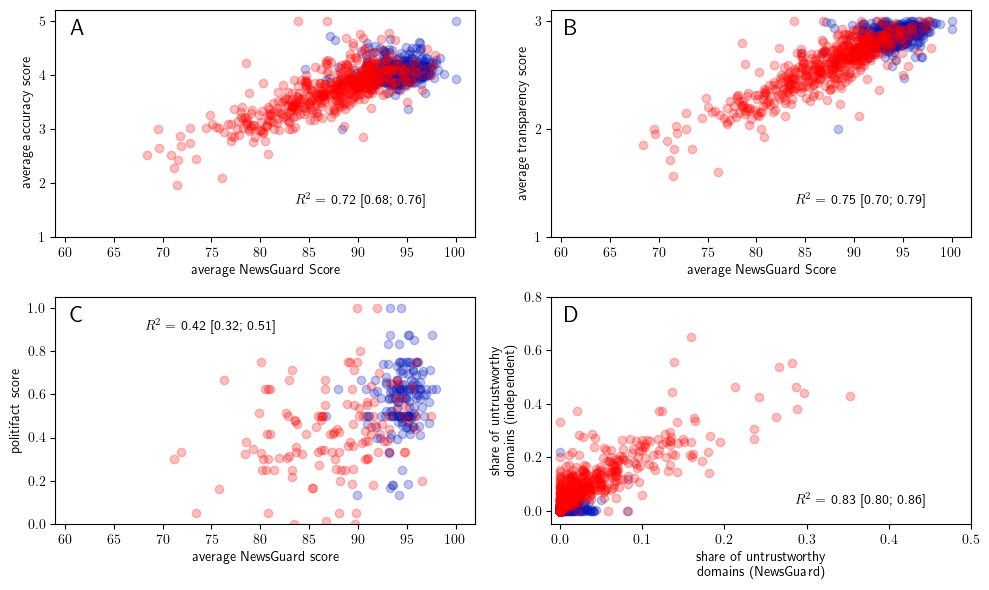

In [110]:
fname = "user_reliability_correlations"
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
dem = users[users["party"] == "Democrat"]
rep = users[users["party"] == "Republican"]
ax = axes[0][0]
ax.scatter(dem["NG_score_mean"], dem["accuracy_mean"], color=demblue, alpha=0.25)
ax.scatter(rep["NG_score_mean"], rep["accuracy_mean"], color=repred, alpha=0.25)
ax.set_xlabel("average NewsGuard Score")
ax.set_ylabel("average accuracy score")
ax.set_xlim(59, 102)
ax.set_ylim(1, 5.2)
ax.set_yticks([1, 2, 3, 4, 5])

ax = axes[0][1]
ax.scatter(dem["NG_score_mean"], dem["transparency_mean"], color=demblue, alpha=0.25)
ax.scatter(rep["NG_score_mean"], rep["transparency_mean"], color=repred, alpha=0.25)
ax.set_xlabel("average NewsGuard Score")
ax.set_ylabel("average transparency score")
ax.set_xlim(59, 102)
ax.set_ylim(1, 3.1)
ax.set_yticks([1, 2, 3])

ax = axes[1][0]
ax.scatter(dem["NG_score_mean"], dem["pf_score"], color=demblue, alpha=0.25)
ax.scatter(rep["NG_score_mean"], rep["pf_score"], color=repred, alpha=0.25)
ax.set_xlabel("average NewsGuard score")
ax.set_ylabel("politifact score")
ax.set_xlim(59, 102)
ax.set_ylim(0, 1.05)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax = axes[1][1]
ax.scatter(dem["NG_unreliable_share"], dem["independent_unreliable_share"], color=demblue, alpha=0.25)
ax.scatter(rep["NG_unreliable_share"], rep["independent_unreliable_share"], color=repred, alpha=0.25)
ax.set_xlabel("share of untrustworthy\ndomains (NewsGuard)")
ax.set_ylabel("share of untrustworthy\ndomains (independent)")
ax.set_xlim(-0.01, 0.5)
ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_ylim(-0.05, 0.8)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])

fig.text(0.3, 0.65, "$R^2 =$ {:1.2f} [{:1.2f}; {:1.2f}]".format(\
        pf_bootstrap["corr_NGScore_accuracy"].mean(),
        pf_bootstrap["corr_NGScore_accuracy"].quantile(0.025),
        pf_bootstrap["corr_NGScore_accuracy"].quantile(0.975)))

fig.text(0.8, 0.65, "$R^2 =$ {:1.2f} [{:1.2f}; {:1.2f}]".format(\
        pf_bootstrap["corr_NGScore_transparency"].mean(),
        pf_bootstrap["corr_NGScore_transparency"].quantile(0.025),
        pf_bootstrap["corr_NGScore_transparency"].quantile(0.975)))

fig.text(0.15, 0.44, "$R^2 =$ {:1.2f} [{:1.2f}; {:1.2f}]".format(\
        pf_bootstrap["corr_NGScore_pf"].mean(),
        pf_bootstrap["corr_NGScore_pf"].quantile(0.025),
        pf_bootstrap["corr_NGScore_pf"].quantile(0.975)))

fig.text(0.8, 0.15, "$R^2 =$ {:1.2f} [{:1.2f}; {:1.2f}]".format(\
        pf_bootstrap["corr_NGShare_ind"].mean(),
        pf_bootstrap["corr_NGShare_ind"].quantile(0.025),
        pf_bootstrap["corr_NGShare_ind"].quantile(0.975)))

fig.text(0.075, 0.933, "A", fontsize=16)
fig.text(0.57, 0.933, "B", fontsize=16)
fig.text(0.075, 0.455, "C", fontsize=16)
fig.text(0.57, 0.455, "D", fontsize=16)

fig.tight_layout()
#plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
#plt.savefig(join(dst, fname + ".pdf"),bbox_inches="tight", facecolor="white")
#plt.savefig(join(dst, fname + ".svg"),bbox_inches="tight", facecolor="white")

## One keyword similarity timelines

In [98]:
fname = "combined_US_politician_twitter_timelines_2010-11-06_to_2022-12-31_honesty_component_scores_glove_singleword.csv.gzip"
cols = ["id", "author_id", "created_at"]
cols = cols + [f"avg_belief_score_{i}" for i in range(37)]
cols = cols + [f"avg_truth_score_{i}" for i in range(37)]
scores = pd.read_csv(
    join(src, "tweets", fname),
    compression="gzip",
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at"],
    usecols=cols,
)

In [99]:
fname = "US_politician_tweets_2010-11-06_to_2022-12-31.csv.gzip"
parties = pd.read_csv(
    join(src, "tweets", fname),
    compression="gzip",
    usecols=["id", "party", "tweet_length"],
    dtype={"id":str}
)

In [100]:
fname = "truth_seeking_p=0.05_swapped_wn_def_example.csv"
truth_keywords = list(pd.read_csv(join(src, "utilities", fname))["truth_seeking"].values)
fname = "belief_speaking_p=0.05_swapped_wn_def_example.csv"
belief_keywords = list(pd.read_csv(join(src, "utilities", fname))["belief_speaking"].values)

In [101]:
scores = scores.merge(parties)

In [104]:
from scipy.stats import linregress

In [ ]:
subset = scores.dropna()
for i in range(37):
    print(i)
    slope_belief, intercept_belief, rval_belief, pval_belief, stderr_belief = \
    linregress(subset["tweet_length"], subset[f"avg_belief_score_{i}"])
    print(f"belief-speaking slope: {slope_belief}, intercept: {intercept_belief}")

    def predict_belief_similarity(tweet_length):
        return intercept_belief + slope_belief * tweet_length

    slope_truth, intercept_truth, rval_truth, pval_truth, stderr_truth = \
        linregress(subset["tweet_length"], subset[f"avg_truth_score_{i}"])
    print(f"truth-seeking slope: {slope_truth}, intercept: {intercept_truth}")

    def predict_truth_similarity(tweet_length):
        return intercept_truth + slope_truth * tweet_length

    scores[f"avg_belief_score_{i}"] = scores\
        .apply(lambda x: x[f"avg_belief_score_{i}"] - predict_belief_similarity(x["tweet_length"]), axis=1)    
    scores[f"avg_truth_score_{i}"] = scores\
        .apply(lambda x: x[f"avg_truth_score_{i}"] - predict_truth_similarity(x["tweet_length"]), axis=1)


In [110]:
scores = scores[scores["party"].isin(["Democrat", "Republican"])]

In [111]:
cols = ["id", "author_id", "created_at", "party"]
belief_scores = scores[cols + [f"avg_belief_score_{i}" for i in range(37)]]
belief_scores.columns = cols + belief_keywords

truth_scores = scores[cols + [f"avg_truth_score_{i}" for i in range(37)]]
truth_scores.columns = cols + truth_keywords

In [112]:
belief_scores = belief_scores.set_index("created_at")
truth_scores = truth_scores.set_index("created_at")

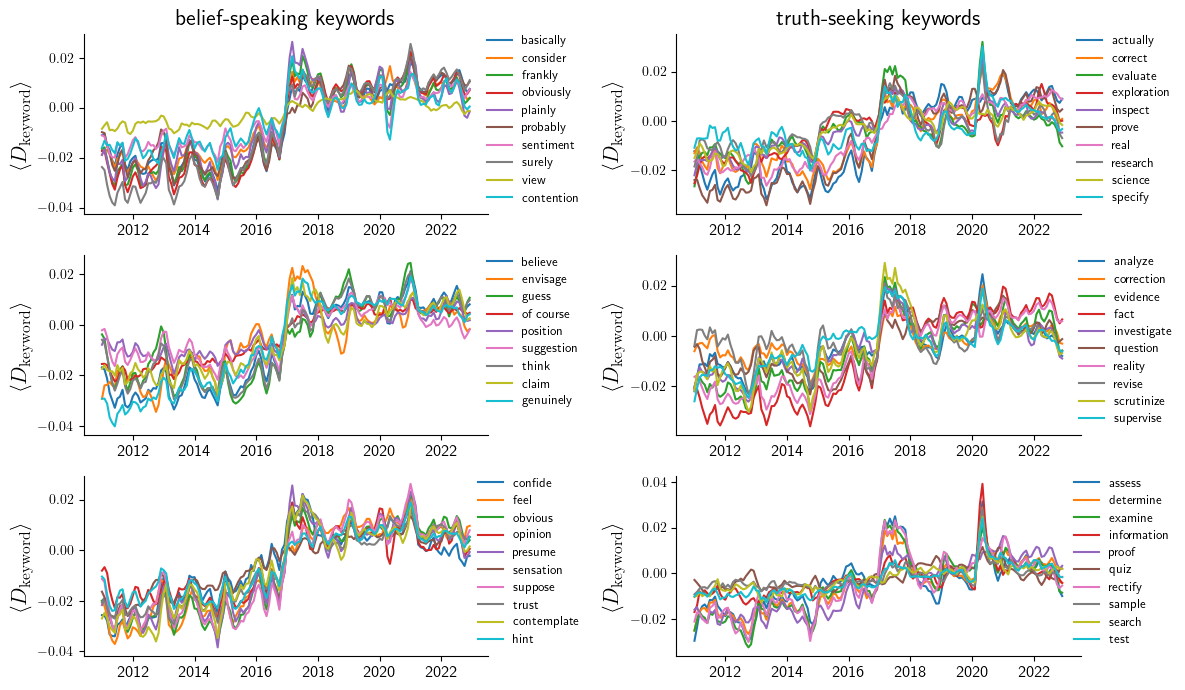

In [117]:
fig, axes = plt.subplots(3, 2, figsize=(12, 7))
colors = sns.color_palette()

for i in range(3):
    for keyword, color in zip(belief_keywords[i::3], colors):
        # somehow the embedding for "seem" didn't work and produced only zeroes
        if keyword == "seem": 
            continue
        ax = axes[i, 0]
        agg = belief_scores[[keyword, "party"]]\
            .groupby(by=[belief_scores.index.year, belief_scores.index.month])\
            .mean()
        agg.index.set_names(["year", "month"], inplace=True)
        agg = agg.reset_index()

        ax.plot(range(len(agg)), agg[keyword].rolling(3).mean(), label=keyword, color=color)

for i in range(3):
    for keyword, color in zip(truth_keywords[i::3], colors):
        ax = axes[i, 1]
        agg = truth_scores[[keyword, "party"]]\
            .groupby(by=[truth_scores.index.year, truth_scores.index.month])\
            .mean()
        agg.index.set_names(["year", "month"], inplace=True)
        agg = agg.reset_index()

        ax.plot(range(len(agg)), agg[keyword].rolling(3).mean(), label=keyword, color=color)
        
for ax in axes.flatten():
    #ax.set_ylim(0, 0.6)
    ax.set_xticks([14, 38, 62, 86, 110, 134])
    ax.set_xticklabels(["2012", "2014", "2016", "2018", "2020", "2022"],
                       fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc=1, bbox_to_anchor=[1.25, 1.05, 0, 0], fontsize=9, frameon=False)
    
for ax in axes[:,0]:
    ax.set_ylabel("$\\left<D_\\mathrm{keyword}\\right>$", fontsize=16)
for ax in axes[:,1]:
    ax.set_ylabel("$\\left<D_\\mathrm{keyword}\\right>$", fontsize=16)
    
axes[0, 0].set_title("belief-speaking keywords", fontsize=16)
axes[0, 1].set_title("truth-seeking keywords", fontsize=16)
fig.tight_layout()

## One-word dictionary exclusion 

In [297]:
results_belief = pd.read_csv(join(src, "tweets", "LME_results_dictionary_belief_reducedbyone.csv"))
results_truth = pd.read_csv(join(src, "tweets", "LME_results_dictionary_truth_reducedbyone.csv"))

In [298]:
original_estimate_belief_rep = -0.052747 #res_glove.params["belief:party[T.Republican]"]
original_estimate_truth_rep = res_glove.params["truth:party[T.Republican]"]
original_estimate_belief_dem = res_glove.params["belief"]
original_estimate_truth_dem = res_glove.params["truth"]

In [299]:
results_belief["party[T.Republican]_belief_estimate"] = results_belief["party[T.Republican]_belief_estimate"] - results_belief["party[T.Republican]_belief_estimate"].mean()
results_belief["belief_belief_estimate"] = results_belief["belief_belief_estimate"] - results_belief["belief_belief_estimate"].mean()

results_truth["party[T.Republican]_truth_estimate"] = results_truth["party[T.Republican]_truth_estimate"] - results_truth["party[T.Republican]_truth_estimate"].mean()
results_truth["truth_truth_estimate"] = results_truth["truth_truth_estimate"] - results_truth["truth_truth_estimate"].mean()

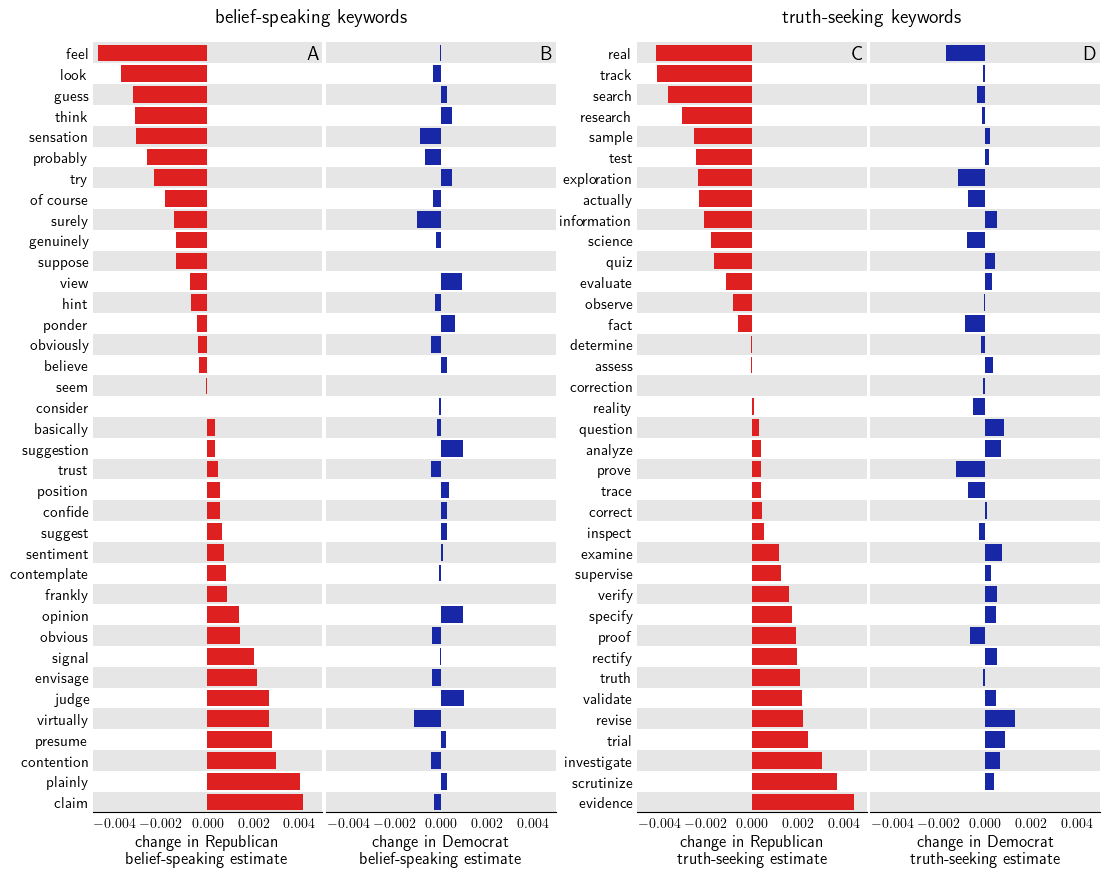

In [377]:
dst = "../../plots"
fig = plt.figure(figsize=(13, 10))

gs = GridSpec(1, 13, figure=fig, hspace=0.05, wspace=0.05)
ax1 = fig.add_subplot(gs[0, 0:3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[0, 6:7])
ax4 = fig.add_subplot(gs[0, 7:10])
ax5 = fig.add_subplot(gs[0, 10:])

results_belief = results_belief.sort_values(by=["party[T.Republican]_belief_estimate"])
results_truth = results_truth.sort_values(by=["party[T.Republican]_truth_estimate"])
order = results_belief["keyword"]

sns.barplot(
    ax=ax1,
    data=results_belief,
    x="party[T.Republican]_belief_estimate",
    y="keyword",
    order=order,
    color=repred,
    zorder=2
)
sns.barplot(
    ax=ax2,
    data=results_belief,
    x="belief_belief_estimate",
    y="keyword",
    order=order,
    color=demblue,
    zorder=2
)

order = results_truth["keyword"]
sns.barplot(
    ax=ax4,
    data=results_truth,
    x="party[T.Republican]_truth_estimate",
    y="keyword",
    order=order,
    color=repred,
    zorder=2
)
sns.barplot(
    ax=ax5,
    data=results_truth,
    x="truth_truth_estimate",
    y="keyword",
    order=order,
    color=demblue,
    zorder=2
)

for ax in [ax1, ax2, ax4, ax5]:
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.tick_params(axis='y', which='major', labelsize=11)

for i, ax in enumerate([ax1, ax2, ax4, ax5]):
    ax.set_ylabel("")
    ax.set_xlim(-0.005, 0.005)
    if i in [1, 3]:
        ax.set_yticks([])
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
ax1.set_xlabel("change in Republican\nbelief-speaking estimate", fontsize=12)
ax2.set_xlabel("change in Democrat\nbelief-speaking estimate", fontsize=12)
ax4.set_xlabel("change in Republican\ntruth-seeking estimate", fontsize=12)
ax5.set_xlabel("change in Democrat\ntruth-seeking estimate", fontsize=12)

for i in range(0, 37, 2):
    for ax in [ax1, ax2, ax4, ax5]:
        rect = patches.Rectangle((-0.005, i-0.5), 0.01, 1, edgecolor='none', facecolor=(0.9, 0.9, 0.9), zorder=1)
        ax.add_patch(rect)

fig.text(0.22, 0.9, "belief-speaking keywords", fontsize=14)
fig.text(0.655, 0.9, "truth-seeking keywords", fontsize=14)
fig.text(0.290, 0.863, "A", fontsize=14)
fig.text(0.470, 0.863, "B", fontsize=14)
fig.text(0.709, 0.863, "C", fontsize=14)
fig.text(0.888, 0.863, "D", fontsize=14)
    
ax3.axis('off')